In [1]:
# First import all packages required
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import os
from openpyxl import load_workbook

import cobra
from cobra.flux_analysis.variability import flux_variability_analysis
from cobra.sampling import sample

import equilibrator_api
from equilibrator_api import ComponentContribution, Reaction, Q_, R, default_T
from equilibrator_api.model import Bounds

from equilibrator_pathway import ThermodynamicModel, Pathway, EnzymeCostModel, EnzymeCostFunction


import seaborn as sns
from matplotlib.patches import Rectangle

import math

# Disable warning messages for infeasible simulations
import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
os.chdir('...')

In [3]:
# Builds a COBRA model from a formatted spreadsheet.
# Also builds a dictionary of metabolites present in the model, as this will be useful later

def build_model_from_excel(path, modelname):
    
    reactions_df = pd.read_excel(path, sheet_name = 'Reactions')
    metabolites_df = pd.read_excel(path, sheet_name = 'Metabolites')

    metabolites = []
    bounds = []
    met_dict = {}
    thermo = {}

    model = cobra.Model(modelname)

    for i,row in metabolites_df.iterrows():

        metabolite = cobra.Metabolite(row['METID'])
        metabolite.id = row['METID']
        metabolite.compartment = row['COMPARTMENT']
        metabolite.name = row['NAME']
        metabolite.formula = row['FORMULA']
        metabolite.charge = row['CHARGE']

        metabolites.append(metabolite)
        met_dict[row['METID']] = row['METID_KEGG']

    model.add_metabolites(metabolites)

    for i,row in reactions_df.iterrows():

        reaction = cobra.Reaction(row['RXNID'])
        model.add_reactions([reaction])

        model.reactions.get_by_id(reaction.id).name = row['RXNID']
        model.reactions.get_by_id(reaction.id).subsystem = row['SUBSYSTEM']
        model.reactions.get_by_id(reaction.id).compartment = row['COMPARTMENT']
        model.reactions.get_by_id(reaction.id).reaction = row['EQUATION']
        
        bounds.append((row['LB'], row['UB']))
    
    for i in range(0,len(model.reactions)):
        model.reactions[i].bounds = bounds[i]
        
    cobra.io.write_sbml_model(model, modelname+'.xml')
        
    return model, met_dict

In [4]:
# Adds an assimilation module to a given COBRA model object from a formatted spreadsheet
# Also updates the metabolite dictionary with metabolites required for the assimilation module

def add_modules(model, path, module, met_dict):
    
    reactions_df = pd.read_excel(path, sheet_name = 'Reactions')
    metabolites_df = pd.read_excel(path, sheet_name = 'Metabolites')
    
    augmented_model = model.copy()

    metabolites = []
    bounds = []
    thermo = {}
    n_rxns = len(model.reactions)

    for i,row in metabolites_df.iterrows():

        metabolite = cobra.Metabolite(row['METID'])
        metabolite.id =row['METID']
        metabolite.compartment = row['COMPARTMENT']
        metabolite.name = row['NAME']
        metabolite.formula = row['FORMULA']
        metabolite.charge = row['CHARGE']

        metabolites.append(metabolite)

        met_dict[row['METID']] = row['METID_KEGG']

    augmented_model.add_metabolites(metabolites)

    for i,row in reactions_df.iterrows():
        
        if row['SUBSYSTEM'] == module:

            reaction = cobra.Reaction(row['RXNID'])
            augmented_model.add_reactions([reaction])

            augmented_model.reactions.get_by_id(reaction.id).name = row['NAME']
            augmented_model.reactions.get_by_id(reaction.id).subsystem = row['SUBSYSTEM']
            augmented_model.reactions.get_by_id(reaction.id).compartment = row['COMPARTMENT']
            augmented_model.reactions.get_by_id(reaction.id).reaction = row['EQUATION']

            bounds.append((row['LB'], row['UB']))
        else:
            continue
    
    for i in range(n_rxns,len(augmented_model.reactions)):
        augmented_model.reactions[i].bounds = bounds[i-n_rxns]
        
    cobra.io.write_sbml_model(augmented_model, model.id+'_'+module.lower()+'.xml')
        
    return augmented_model, met_dict

In [5]:
# Creates a production envelope using a given COBRA model

def production_envelope(model, carbon_source, flux_bounds, product_objective):
    
    temp = model.copy()
    
    for reaction in flux_bounds:
        temp.reactions.get_by_id(reaction).bounds = flux_bounds[reaction]
    
    temp.objective = 'BIOMASS'
    
    # Block non-native reactions
    
    temp.reactions.XFPK1.bounds = (0,0)
    temp.reactions.XFPK2.bounds = (0,0)
    temp.reactions.aclAB.bounds = (0,0)
    
    solution = cobra.flux_analysis.pfba(temp)
    
    gr_max = solution['BIOMASS']
    
    growth_rates = np.linspace(0, gr_max, 100)
    
    temp.objective = product_objective

    results = [[0 for x in range(5)] for y in range(100)]
    
    for i in range(0,100):

        temp.reactions.BIOMASS.bounds = (growth_rates[i], 1000)

        solution = cobra.flux_analysis.pfba(temp)
        
        if solution[product_objective] <= 0:
            continue
        else:
            #Store desired fluxes in results array
            results[i][0] = solution[product_objective] #PHB flux
            results[i][1] = solution['BIOMASS'] #Biomass production
            results[i][2] = -solution['Ex_CO2']
            results[i][3] = solution['Ex_H2']
            results[i][4] = solution['RUBISCO']
        
    df = pd.DataFrame(results) #Convert results array to dataframe
    df = df.rename(index=str, columns={0: product_objective, 1:'Biomass', 2:'CO2', 3:'H2', 4:'RUBISCO'})
    df = df.loc[(df!=0).any(axis=1)]

    return df

# Stoichiometry of CO$_2$ Reassimilation

For various carbon sources, what are the costs and benefits of CO$_2$ reassimilation?

First, the H$_2$ demand for full CO$_2$ reassimilation is estimated. Then, the thermodynamic feasibility of reassimilation is estimated.

In [645]:
# Build a model for each carbon source, then check to make sure growth is possible

path = 'C:\\Users\\euler\\Documents\\Research\\Mixotrophy\\Cupriavidus_Core_PCB_Submission.xlsx'
modules_path = 'C:\\Users\\euler\\Documents\\Research\\Mixotrophy\\Consumption_Modules_PCB_Submission.xlsx'

cnec_core, cnec_dict = build_model_from_excel(path,'cnec_core')

carbon_source = {'CO2': (1, 44, 0),
                 'Formate': (1, 46, 2), 
                 'Succinate': (4, 118, 3.5), 
                 'Acetate': (2, 60, 4), 
                 'Fructose': (6, 180, 4), 
                 'Adipate':(6, 146, 4.3),
                 'Glycerol':(3, 92, 4.67),
                 'Butyrate':(4, 88, 5),
                 'EG':(2, 62, 5),
                 '14BDO':(4, 90, 5.5), 
                 'EtOH':(2, 46, 6),
                 'MeOH':(1, 32, 6)}
cnec_models = {}

for carbon in carbon_source.keys():
    
    if carbon == 'CO2':
        cnec_models[carbon] = cnec_core.copy()
        cnec_models[carbon].reactions.Ex_CO2.bounds = (1,1)
        cnec_models[carbon].reactions.Ex_H2.bounds = (0,1000)
        cnec_models[carbon].objective = 'BIOMASS'
        
    elif carbon == 'Fructose':
        cnec_models[carbon], cnec_dict = add_modules(cnec_core, modules_path, carbon, cnec_dict)
        cnec_models[carbon].reactions.get_by_id('Ex_'+carbon).bounds = (1,1)
        
        #Forces ED pathway utilization instead of PPP, which has a higher yield
        cnec_models[carbon].reactions.get_by_id('PGI').bounds = (1,1) 
        cnec_models[carbon].objective = 'BIOMASS'
    
    elif carbon == 'Butyrate':
        cnec_models[carbon], cnec_dict = add_modules(cnec_core, modules_path, carbon, cnec_dict)
        cnec_models[carbon].reactions.get_by_id('Ex_'+carbon).bounds = (1,1)
        
        #Necessary to avoid futile cycling of acetate
        cnec_models[carbon].reactions.get_by_id('ACS').bounds = (0,0)
        cnec_models[carbon].objective = 'BIOMASS'
    
    elif carbon == 'Acetate':
        cnec_models[carbon], cnec_dict = add_modules(cnec_core, modules_path, carbon, cnec_dict)
        cnec_models[carbon].reactions.get_by_id('Ex_'+carbon).bounds = (1,1)
        
        #Model predicts ACK for higher yield, but ACS is more realistic
        cnec_models[carbon].reactions.get_by_id('ACK').bounds = (0,0)
        cnec_models[carbon].objective = 'BIOMASS'

    else:
        cnec_models[carbon], cnec_dict = add_modules(cnec_core, modules_path, carbon, cnec_dict)
        cnec_models[carbon].reactions.get_by_id('Ex_'+carbon).bounds = (1,1)
        cnec_models[carbon].objective = 'BIOMASS'
    
    try:
        solution = cobra.flux_analysis.pfba(cnec_models[carbon])
        print(solution['BIOMASS'])
    except:
        print(carbon+' is infeasible')

0.025068939583855608
0.005240266205523241
0.05752444789035344
0.028034108164934013
0.09753343086676428
0.1025435810219341
0.0589063900627482
0.07002976264912547
0.034935108036821656
0.08884376189871851
0.04739066972494384
0.01572079861656975


In [646]:
production_envelopes = {}
production_envelopes_H2 = {}

for carbon in carbon_source.keys():
    
    if carbon == 'CO2':
        
        flux_bounds = {'Ex_CO2':(1,1), 'Ex_H2':(-1000,1000), 'RUBISCO':(0,1000)}
        
        production_envelopes[carbon] = production_envelope(cnec_models[carbon], carbon, flux_bounds, 'Ex_PHB')
        production_envelopes_H2[carbon] = production_envelope(cnec_models[carbon], carbon, flux_bounds, 'Ex_PHB')
        
    elif carbon_source[carbon][0] == 1:
    
        production_envelopes[carbon] = production_envelope(cnec_models[carbon], carbon, 
                                                           {'Ex_CO2':(-1000,0), 'Ex_H2':(0,0), 'RUBISCO':(0,1000)}, 
                                                           'Ex_PHB')    
        production_envelopes_H2[carbon] = production_envelope(cnec_models[carbon], carbon, 
                                                              {'Ex_CO2':(-1000,0), 'Ex_H2':(-1000,1000), 'RUBISCO':(0,1000)}, 
                                                              'Ex_PHB')
        
    else:
    
        production_envelopes[carbon] = production_envelope(cnec_models[carbon], carbon, 
                                                           {'Ex_CO2':(-1000,0), 'Ex_H2':(0,0), 'RUBISCO':(0,0)}, 
                                                           'Ex_PHB')
        
        production_envelopes_H2[carbon] = production_envelope(cnec_models[carbon], carbon, 
                                                              {'Ex_CO2':(-1000,0), 'Ex_H2':(-1000,1000), 'RUBISCO':(0,1000)}, 
                                                              'Ex_PHB')

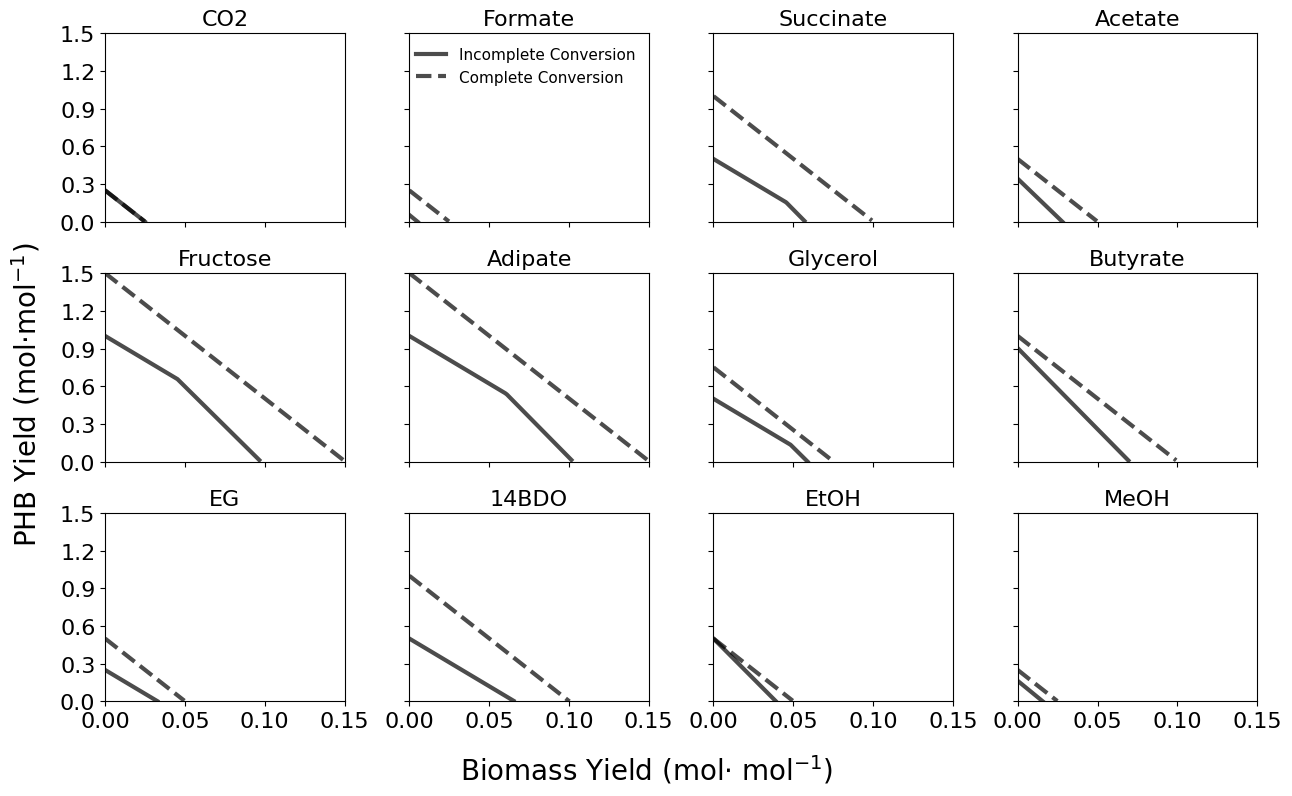

In [647]:
fig, ax = plt.subplots(3,4, figsize = (13,8), sharex = True, sharey = True)

ax = ax.flatten()
i = 0

for carbon in carbon_source.keys():
    
    ax[i].plot(production_envelopes[carbon]['Biomass'], production_envelopes[carbon]['Ex_PHB'], 
               color = 'k', linewidth = 3, alpha = 0.7, label = r'Incomplete Conversion')
    ax[i].plot(production_envelopes_H2[carbon]['Biomass'], production_envelopes_H2[carbon]['Ex_PHB'], 
               color = 'k', linewidth = 3, linestyle = '--', alpha = 0.7, label = r'Complete Conversion')

    ax[i].set_title(carbon,fontsize=16)
    ax[i].tick_params(axis='both', labelsize=16)
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    
    ax[i].set_xlim(0,0.15)
    ax[i].set_ylim(0,1.5)
    
    if carbon == 'Formate':
        ax[i].legend(frameon=False, loc='best', fontsize=11)
    
    i += 1

fig.supylabel(r'PHB Yield (mol$\cdot$mol$^{-1}$)', fontsize=20, x = 0.01)
fig.supxlabel(r'Biomass Yield (mol$\cdot$ mol$^{-1}$)', fontsize=20, y = 0.01)
fig.tight_layout()

plt.savefig('production_envelopes.pdf', bbox_inches='tight')

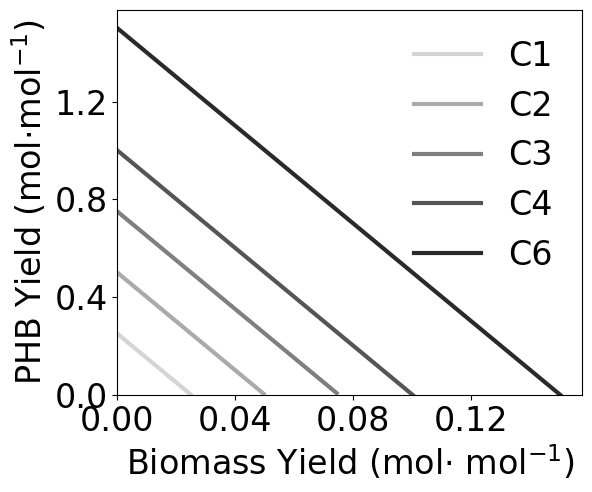

In [425]:
shortlist = ['Formate', 'EG', 'Glycerol', '14BDO', 'Fructose']

fig, ax = plt.subplots(1,1, figsize = (6,5))

for i in range(0,len(shortlist)):  
    
    carbon = shortlist[i]
    shade = (i+1)/(len(shortlist) + 1)
    label = str(carbon_source[carbon][0])
    
    ax.plot(production_envelopes_H2[carbon]['Biomass'], production_envelopes_H2[carbon]['Ex_PHB'], 
            linewidth = 3, color = 'k', linestyle = '-', alpha = shade, label = 'C'+label)

ax.set_ylabel(r'PHB Yield (mol$\cdot$mol$^{-1}$)', fontsize=24)
ax.set_xlabel(r'Biomass Yield (mol$\cdot$ mol$^{-1}$)', fontsize=24)
ax.legend(frameon=False, loc = 'best', fontsize = 24)
ax.set_ylim(0,)
ax.set_xlim(0,)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

ax.tick_params(axis='both', labelsize=24)

#plt.savefig('stoichiometric_conversion.pdf', bbox_inches='tight')

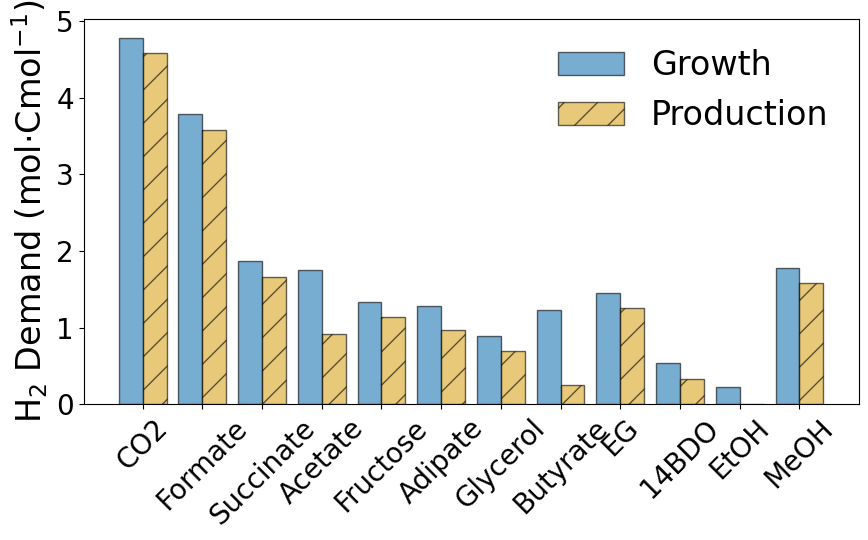

In [648]:
# Plot the hydrogen required to achieve full assimilation for growth and production extremes

x = np.arange(len(carbon_source.keys()))
growth = [production_envelopes_H2[x]['H2'][-1]/carbon_source[x][0] for x in carbon_source.keys()]
production = [production_envelopes_H2[x]['H2'][0]/carbon_source[x][0] for x in carbon_source.keys()]
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, growth, width, label = 'Growth', alpha = 0.6, edgecolor = "black")
ax.bar(x+width/2, production, width, label = 'Production', color = 'goldenrod',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel('H$_2$ Demand (mol$\cdot$Cmol$^{-1}$)', fontsize=24)
ax.legend(frameon=False, loc = 'best', fontsize = 24)
ax.tick_params(axis='both', labelsize=20)

_=ax.set_xticks(ticks = x ,labels = carbon_source.keys(), rotation =45)

plt.savefig('H2_demand.pdf', bbox_inches = 'tight')

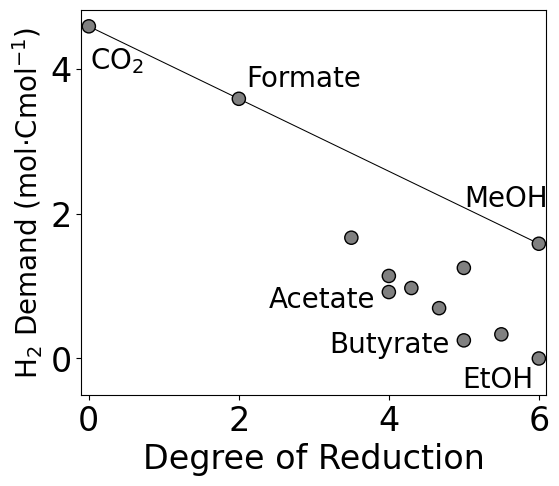

In [654]:
DOR = [carbon_source[x][2] for x in carbon_source.keys()]
demand = [(4.5833-x/2) for x in DOR]

fig, ax = plt.subplots(1,1, figsize = (6,5))

ax.scatter(DOR, production, color = 'grey', edgecolors = 'k', sizes = 90*np.ones(len(DOR)))
ax.plot(DOR, demand, linestyle = '-', linewidth = 0.75, color = 'k', zorder=0)

ax.set_xlabel(r'Degree of Reduction', fontsize=24)
ax.set_ylabel(r'H$_2$ Demand (mol$\cdot$Cmol$^{-1}$)', fontsize=20)
ax.tick_params(axis='both', labelsize=24)
ax.set_ylim(-0.5,)
ax.set_xlim(-0.1,6.1)

ax.text(0.01, 4, 'CO$_2$', fontsize=20)
ax.text(2.1, 3.75, 'Formate', fontsize=20)
#ax.text(3.3, 2.35, 'Succinate', fontsize=20)
ax.text(2.4, 0.7,'Acetate', fontsize = 20)
ax.text(3.2, 0.08,'Butyrate', fontsize = 20)
#ax.text(2.5, 1.6, 'Fructose', fontsize=20)
#ax.text(4.2, 2.05, 'Adipate', fontsize=20)
#ax.text(3, 1.2, 'Glycerol', fontsize=20)
#ax.text(4.9, 1.75, 'EG', fontsize=20)
ax.text(4.98,-0.4,'EtOH', fontsize = 20)
#ax.text(4,0.4, '14BDO', fontsize=20)
ax.text(5,2.1, 'MeOH', fontsize=20)


plt.savefig('H2_per_DOR.pdf', bbox_inches = 'tight')

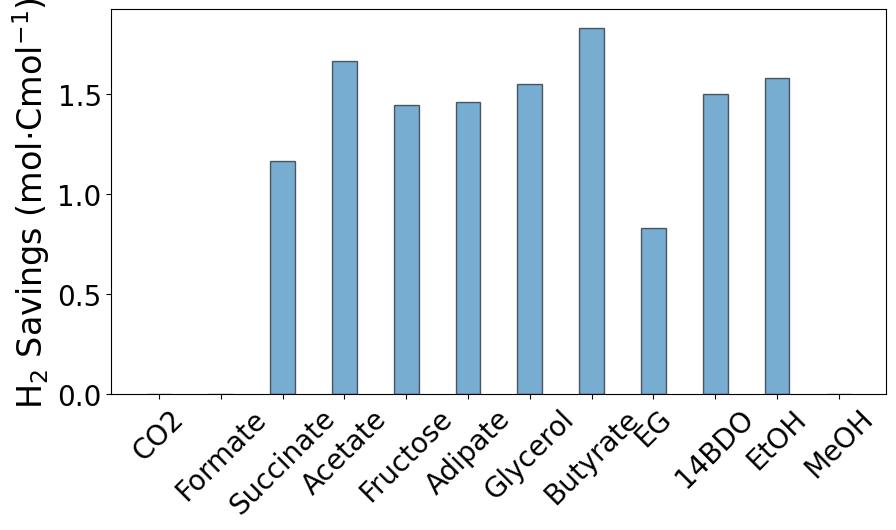

In [655]:
# Plot the hydrogen required to achieve full assimilation for growth and production extremes

x = np.arange(len(carbon_source.keys()))
savings = []
for i in range(0,len(demand)):
    savings.append(demand[i]-production[i])
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x, savings, width, alpha = 0.6, edgecolor = "black")

ax.set_ylabel('H$_2$ Savings (mol$\cdot$Cmol$^{-1}$)', fontsize=24)
ax.set_ylim(0,)
#ax.legend(frameon=False, loc = 'best', fontsize = 24)
ax.tick_params(axis='both', labelsize=20)

_=ax.set_xticks(ticks = x ,labels = carbon_source.keys(), rotation =45)

plt.savefig('H2_savings.pdf', bbox_inches = 'tight')

In [656]:
yields = {}

for carbon in carbon_source:
    if carbon_source[carbon][0] == 1:
        continue
    else:
        rubisco = np.linspace(0, carbon_source[carbon][0],20)

        cnec_models[carbon].objective = 'BIOMASS'
        cnec_models[carbon].reactions.get_by_id('Ex_H2').bounds = (0,0)
        cnec_models[carbon].reactions.get_by_id('Ex_CO2').bounds = (-1000,0)
        
        temp = []

        for lb in rubisco:
            cnec_models[carbon].reactions.get_by_id('RUBISCO').bounds = (lb,1000)
            solution = cobra.flux_analysis.pfba(cnec_models[carbon])
            temp.append(solution['BIOMASS'])
    
    yields[carbon] = [rubisco/carbon_source[carbon][0], temp]

In [657]:
yields_phb = {}

for carbon in carbon_source:
    if carbon_source[carbon][0] == 1:
        continue
    else:
        rubisco = np.linspace(0, carbon_source[carbon][0],20)

        cnec_models[carbon].objective = 'Ex_PHB'
        cnec_models[carbon].reactions.get_by_id('Ex_H2').bounds = (0,0)
        cnec_models[carbon].reactions.get_by_id('Ex_CO2').bounds = (-1000,0)
        
        temp = []

        for lb in rubisco:
            cnec_models[carbon].reactions.get_by_id('RUBISCO').bounds = (lb,1000)
            solution = cobra.flux_analysis.pfba(cnec_models[carbon])
            temp.append(solution['Ex_PHB'])
    
    yields_phb[carbon] = [rubisco/carbon_source[carbon][0], temp]

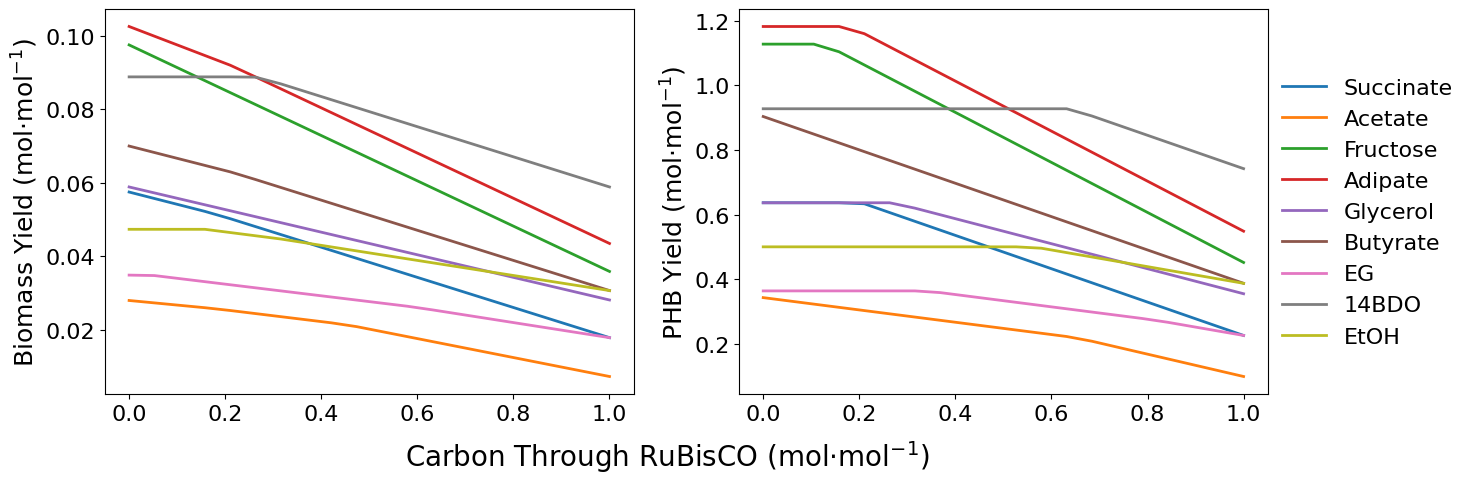

In [658]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax = ax.flatten()

for carbon in yields:
    ax[0].plot(yields[carbon][0], yields[carbon][1], linewidth = 2)
    ax[1].plot(yields_phb[carbon][0], yields_phb[carbon][1], label = carbon, linewidth = 2)

ax[0].set_ylabel(r'Biomass Yield (mol$\cdot$mol$^{-1}$)', fontsize=18)
ax[1].set_ylabel(r'PHB Yield (mol$\cdot$mol$^{-1}$)', fontsize=18)
ax[1].legend(frameon=False, loc = (1.01, 0.1), fontsize = 16)

ax[0].tick_params(axis='both', labelsize=16)
ax[1].tick_params(axis='both', labelsize=16)

fig.supxlabel(r'Carbon Through RuBisCO (mol$\cdot$mol$^{-1}$)', fontsize=20, y = -0.05)

plt.savefig('yield_rubisco.pdf', bbox_inches = 'tight')

# Thermodynamic Analysis

In [334]:
# Establish thermodynamic conditions

C_necator_con = {
            "p_h": str(Q_("7.4")),
            "p_mg": str(Q_(3)),
            "ionic_strength": str(Q_('200 mM')),
            "temperature": str(Q_(30+273.15,"K")),
            "kcat_source": "fwd",
}

cc= ComponentContribution()

# Create a metabolite dictionary for thermodynamic model generation

compound_dict = {}

for name in cnec_dict.keys():
    try:
        compound_dict[name] = cc.get_compound(cnec_dict[name])
    except:
        continue

# Set default bounds for thermodynamic models
        
f = '...\\cofactors_cnec.csv'
        
bounds = Bounds.from_csv(f=f,
                         comp_contrib = cc,
                         default_lb = Q_(1e-6,'molar'),
                         default_ub = Q_(1e-2,'molar'))

In [21]:
# Tranlates reactions from a COBRA model into a format that the thermodynamic package understands using a dictionary object

def translate_reactions(model, met_dict):
    
    Nr = len(model.reactions)

    translated = {}

    for i in range(0,Nr):
        reaction_id = model.reactions[i].id
        
        temp = str(model.reactions[i].reaction)
        temp = temp.split(' ')

        s = ''

        for item in temp:
            if item in met_dict:
                if type(met_dict[item]) == float:
                    s += ' '+item
                else:
                    s += ' '+met_dict[item]
            else:
                s += ' '+item

        try:
            reaction_object = cc.parse_reaction_formula(s)
            translated[reaction_id] = reaction_object
        except:
            continue
    
    return translated

In [94]:
# Gets flux distribution using pFBA for a COBRA model, given some flux bounds
# This is in preparation for building a thermodynamic model, so transport, export, and biomass fluxes 
# are excluded from the return

def get_fluxes(model, flux_bounds, objective):
    
    model.objective = objective
    
    for reaction in flux_bounds:
        model.reactions.get_by_id(reaction).bounds = flux_bounds[reaction]
 
    solution = cobra.flux_analysis.pfba(model)
    
    fluxes = [solution[x.id] for x in model.reactions if 'Ex_' not in x.id and 'Trp_' not in x.id and 'BIOMASS' not in x.id]
    
    for i in range(0,len(fluxes)):
        if abs(fluxes[i]) < 1e-3:
            fluxes[i] = 0.0
   
    return fluxes

In [23]:
# From a COBRA model, dictionaries for metabolites and thermodynamic compounds, and fluxes, creates a thermodynamic model

def build_thermo_model(model, cnec_dict, compound_dict, fluxes):

    translated = translate_reactions(model, cnec_dict)

    stoichiometry = cobra.util.array.create_stoichiometric_matrix(model)

    stoich = pd.DataFrame(stoichiometry,index=[x.id for x in model.metabolites], 
                          columns = [x.id for x in model.reactions])
    stoich = stoich.drop(columns=['Ex_Biomass','BIOMASS', 'Ex_PHB'])
    stoich = stoich.drop(['biomass[c]','PHB[c]'])
    stoich = stoich.drop(columns=[x for x in stoich.columns if 'Ex_' in x or 'Trp_' in x])
    
    fluxes = Q_(fluxes)

    thermo_model = ThermodynamicModel(S = stoich,
                                 compound_dict = compound_dict,
                                 reaction_dict= translated,
                                 fluxes = fluxes,
                                 comp_contrib = cc,
                                 bounds=bounds)

    
    return thermo_model

In [121]:
thermo_models_no_rubisco = {}
thermo_models = {}

for carbon in carbon_source.keys():
    
    if carbon_source[carbon][0] != 1:
        
        uptake_flux = 'Ex_'+carbon
        
        flux_bounds = {'Ex_CO2': (-1000,1000), 'Ex_H2': (0, 0), 'RUBISCO': (0,0), uptake_flux: (1,1)}
        fluxes = get_fluxes(cnec_models[carbon], flux_bounds, 'BIOMASS')
        thermo_models_no_rubisco[carbon] = build_thermo_model(cnec_models[carbon], cnec_dict, compound_dict, fluxes)

        flux_bounds = {'Ex_CO2': (-1000,1000), 'Ex_H2': (0, 0), 'RUBISCO': (0,1000), uptake_flux: (1,1)}
        fluxes = get_fluxes(cnec_models[carbon], flux_bounds, 'BIOMASS')
        thermo_models[carbon] = build_thermo_model(cnec_models[carbon], cnec_dict, compound_dict, fluxes)

    else:
        continue

In [122]:
nonc1mdfs_no_rubisco = {}
nonc1mdfs = {}

for carbon in thermo_models_no_rubisco.keys():
    
    nonc1mdfs_no_rubisco[carbon] = thermo_models_no_rubisco[carbon].mdf_analysis().score
    nonc1mdfs[carbon] = thermo_models[carbon].mdf_analysis().score

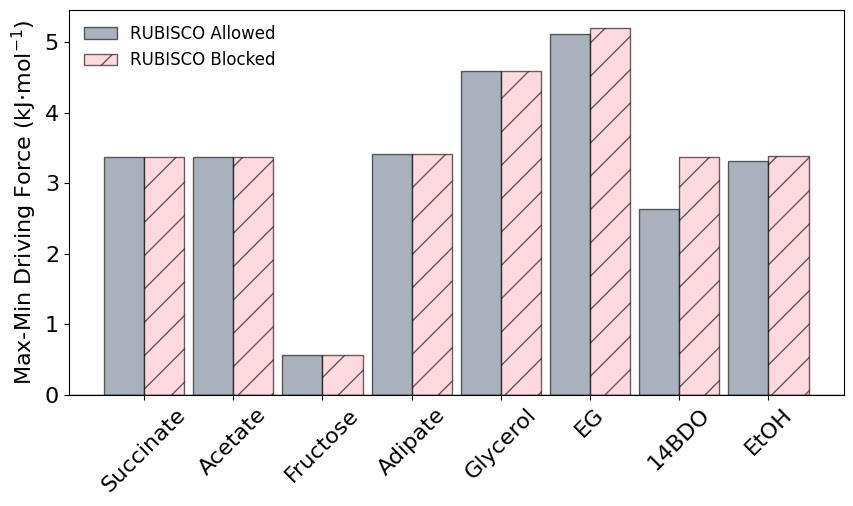

In [123]:
x = np.arange(len(nonc1mdfs.keys())) 
rubisco = [nonc1mdfs[x] for x in nonc1mdfs.keys()]
no_rubisco = [nonc1mdfs_no_rubisco[x] for x in nonc1mdfs_no_rubisco.keys()]
width = 0.45

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, rubisco, width, label = 'RUBISCO Allowed', alpha = 0.6, color = 'slategrey', edgecolor = "black")
ax.bar(x+width/2, no_rubisco, width, label = 'RUBISCO Blocked', color = 'pink',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 12)
ax.tick_params(axis='both', labelsize=16)

ax.axhline(0,linewidth = 1, color = 'k')

_=ax.set_xticks(ticks = x, labels = nonc1mdfs.keys(), rotation =45)

#plt.savefig('rubisco_requirement_growth.pdf', bbox_inches = 'tight')

In [663]:
# Set appropriate RUBISCO bounds based on above 

cnec_models['CO2'].reactions.get_by_id('RUBISCO').bounds = (0,1000)
cnec_models['Formate'].reactions.get_by_id('RUBISCO').bounds = (0,1000)
cnec_models['Succinate'].reactions.get_by_id('RUBISCO').bounds = (0,0)
cnec_models['Acetate'].reactions.get_by_id('RUBISCO').bounds = (0,0)
cnec_models['Fructose'].reactions.get_by_id('RUBISCO').bounds = (0,0)
cnec_models['Adipate'].reactions.get_by_id('RUBISCO').bounds = (0,0)
cnec_models['Glycerol'].reactions.get_by_id('RUBISCO').bounds = (0,0)
cnec_models['EG'].reactions.get_by_id('RUBISCO').bounds = (0,0)
cnec_models['14BDO'].reactions.get_by_id('RUBISCO').bounds = (0,0)
cnec_models['Butyrate'].reactions.get_by_id('RUBISCO').bounds = (0,0)
cnec_models['EtOH'].reactions.get_by_id('RUBISCO').bounds = (0,1000)
cnec_models['MeOH'].reactions.get_by_id('RUBISCO').bounds = (0,1000)

In [664]:
thermo_models_growth = {}
thermo_models_prod = {}

for carbon in cnec_models.keys():
    
    uptake_flux = 'Ex_'+carbon
    
    if carbon == 'CO2':
        flux_bounds = {'Ex_CO2': (1,1), 'Ex_H2': (-1000, 1000), 'RUBISCO':(0,1000)}
    
    else:
        flux_bounds = {'Ex_CO2': (-1000,1000), 'Ex_H2': (0, 0), uptake_flux:(1,1), 'CITL':(0,0)}
    
    fluxes = get_fluxes(cnec_models[carbon], flux_bounds, 'Ex_PHB')
    thermo_models_prod[carbon] = build_thermo_model(cnec_models[carbon], cnec_dict, compound_dict, fluxes)
    
    fluxes = get_fluxes(cnec_models[carbon], flux_bounds, 'BIOMASS')
    thermo_models_growth[carbon] = build_thermo_model(cnec_models[carbon], cnec_dict, compound_dict, fluxes)

In [665]:
mdfs_growth = {}
mdfs_prod = {}

for carbon in thermo_models_growth.keys():

    try:
        mdfs_growth[carbon] = thermo_models_growth[carbon].mdf_analysis().score
        mdfs_prod[carbon] = thermo_models_prod[carbon].mdf_analysis().score
    except:
        print('no mdf for '+carbon)

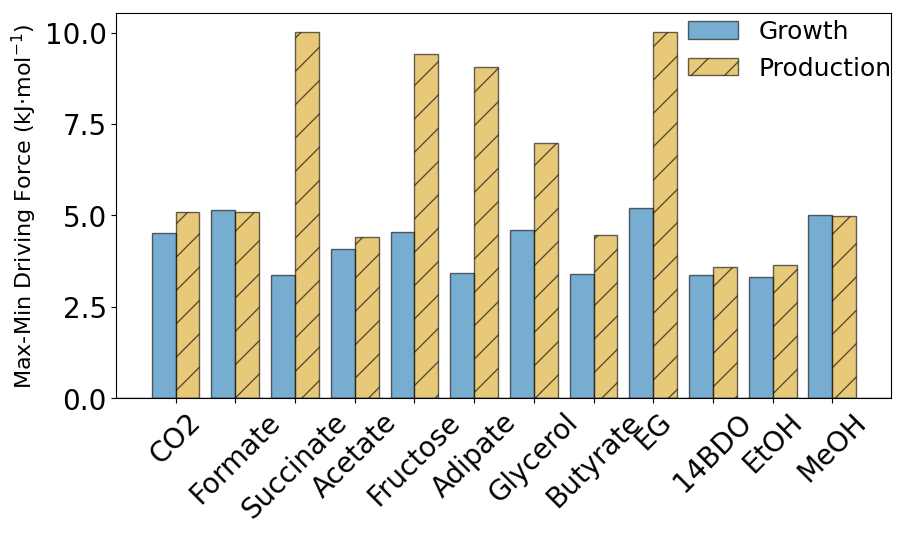

In [666]:
x = np.arange(len(mdfs_prod))
growth = [mdfs_growth[x] for x in mdfs_prod.keys()]
production = [mdfs_prod[x] for x in mdfs_prod.keys()]
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, growth, width, label = 'Growth', alpha = 0.6, edgecolor = "black")
ax.bar(x+width/2, production, width, label = 'Production', color = 'goldenrod',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = (0.725,0.8), fontsize = 18)
ax.tick_params(axis='both', labelsize=20)
ax.axhline(0,linewidth = 1, color = 'k')
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

_=ax.set_xticks(ticks = x,labels = mdfs_prod.keys(), rotation =45)

plt.savefig('baseline mdfs.pdf', bbox_inches = 'tight')

In [668]:
thermo_models_reassim_growth = {}
thermo_models_reassim_prod = {}

for carbon in cnec_models.keys():
    
    uptake_flux = 'Ex_'+carbon
    
    if carbon == 'EtOH': # Ethanol requires CO2 uptake without hydrogen
        flux_bounds = {'Ex_CO2': (-1000,1000), 'Ex_H2': (0, 0), 'RUBISCO': (0,1000)}
        flux_bounds[uptake_flux] = (1,1)        
    elif carbon == 'CO2':
        flux_bounds = {'Ex_CO2': (1,1), 'Ex_H2': (-1000, 1000), 'RUBISCO': (0,1000)}
    else:
        flux_bounds = {'Ex_CO2': (0,0), 'Ex_H2': (-1000, 1000), 'RUBISCO': (0,1000)}
        flux_bounds[uptake_flux] = (1,1)
    
    cnec_models[carbon].objective = 'Ex_PHB'
    
    fluxes = get_fluxes(cnec_models[carbon], flux_bounds, 'Ex_PHB')
    thermo_models_reassim_prod[carbon] = build_thermo_model(cnec_models[carbon], cnec_dict, compound_dict, fluxes)
    
    cnec_models[carbon].objective = 'BIOMASS'

    fluxes = get_fluxes(cnec_models[carbon], flux_bounds, 'BIOMASS')
    thermo_models_reassim_growth[carbon] = build_thermo_model(cnec_models[carbon], cnec_dict, compound_dict, fluxes)

In [708]:
mdfs_reassim_growth = {}
mdfs_reassim_prod = {}

for carbon in thermo_models_reassim_growth.keys():

    try:
        mdfs_reassim_growth[carbon] = thermo_models_reassim_growth[carbon].mdf_analysis().score
        mdfs_reassim_prod[carbon] = thermo_models_reassim_prod[carbon].mdf_analysis().score
    except:
        print('no mdf for '+carbon)

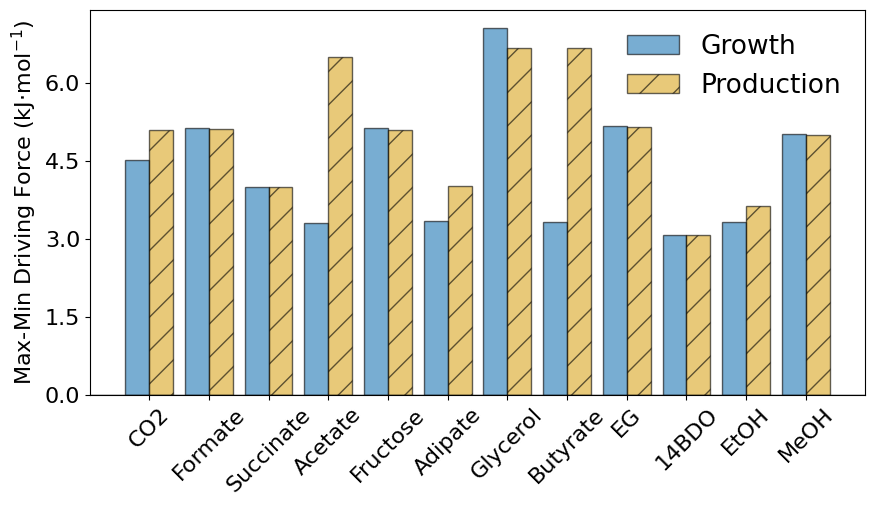

In [670]:
x = np.arange(len(mdfs_reassim_prod))
growth = [mdfs_reassim_growth[x] for x in mdfs_reassim_prod.keys()]
production = [mdfs_reassim_prod[x] for x in mdfs_reassim_prod.keys()]
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, growth, width, label = 'Growth', alpha = 0.6, edgecolor = "black")
ax.bar(x+width/2, production, width, label = 'Production', color = 'goldenrod',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 19)
ax.tick_params(axis='both', labelsize=16)
ax.axhline(0,linewidth = 1, color = 'k')
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

_=ax.set_xticks(ticks = x,labels = mdfs_reassim_prod.keys(), rotation =45)

plt.savefig('reassimilation mdfs.pdf', bbox_inches = 'tight')

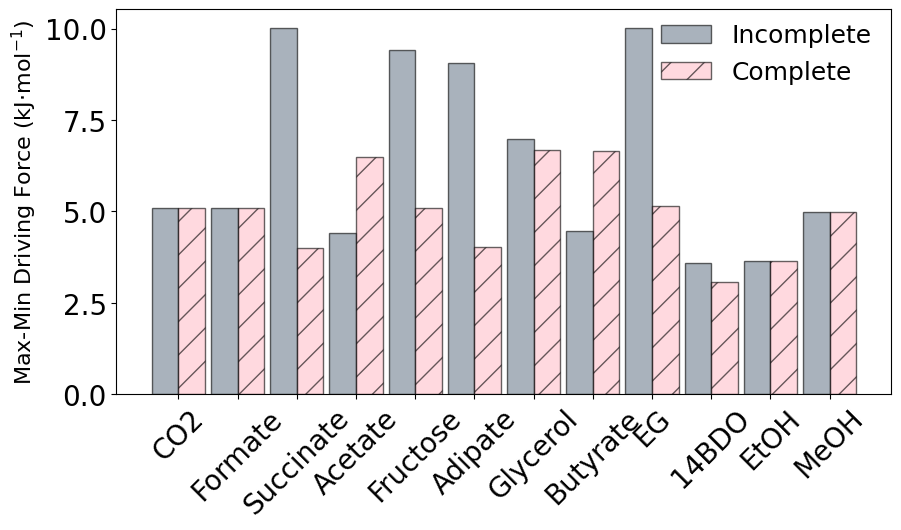

In [671]:
x = np.arange(len(mdfs_reassim_prod.keys())) 
no_reassim = [mdfs_prod[x] for x in mdfs_prod.keys()]
reassim = [mdfs_reassim_prod[x] for x in mdfs_reassim_prod.keys()]
width = 0.45

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, no_reassim, width, label = 'Incomplete', alpha = 0.6, color = 'slategrey', edgecolor = "black")
ax.bar(x+width/2, reassim, width, label = 'Complete', color = 'pink',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = (0.69,0.78), fontsize = 18)
ax.tick_params(axis='both', labelsize=20)

ax.yaxis.set_major_locator(plt.MaxNLocator(5))

_=ax.set_xticks(ticks = x, labels = mdfs_reassim_prod.keys(), rotation =45)

plt.savefig('reassim_no_reassim_comparison.pdf', bbox_inches = 'tight')

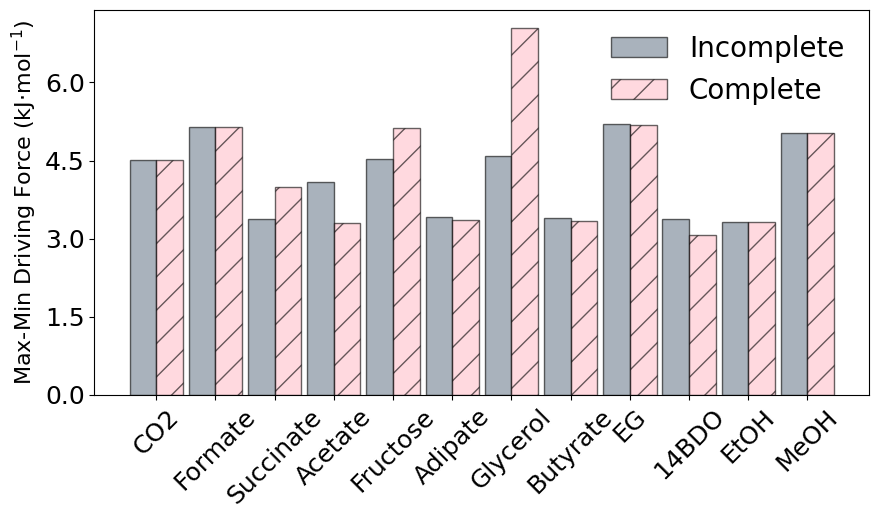

In [672]:
x = np.arange(len(mdfs_reassim_growth.keys())) 
no_reassim = [mdfs_growth[x] for x in mdfs_growth.keys()]
reassim = [mdfs_reassim_growth[x] for x in mdfs_reassim_growth.keys()]
width = 0.45

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, no_reassim, width, label = 'Incomplete', alpha = 0.6, color = 'slategrey', edgecolor = "black")
ax.bar(x+width/2, reassim, width, label = 'Complete', color = 'pink',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 20)
ax.tick_params(axis='both', labelsize=18)

ax.yaxis.set_major_locator(plt.MaxNLocator(5))

_=ax.set_xticks(ticks = x, labels = mdfs_reassim_growth.keys(), rotation =45)

plt.savefig('reassim_no_reassim_comparison_growth.pdf', bbox_inches = 'tight')

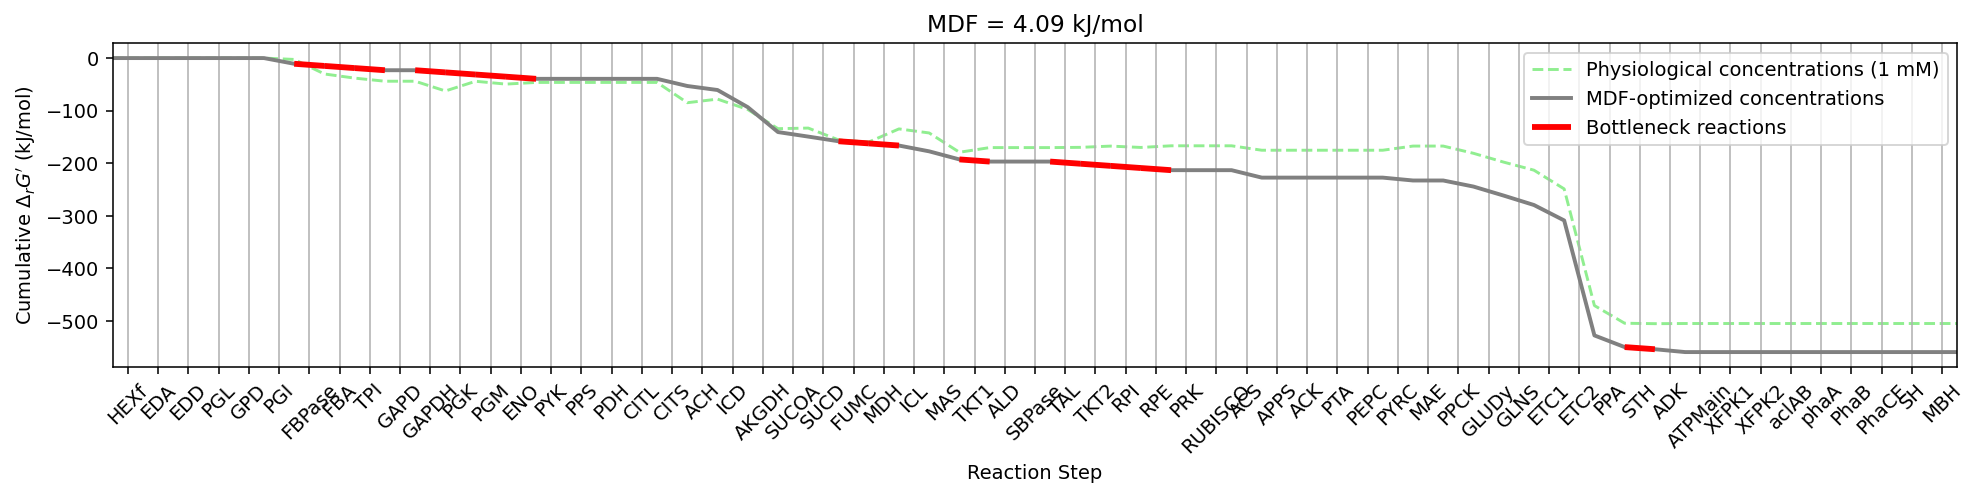

In [798]:
cnec_models['Acetate'].objective = 'BIOMASS'
flux_bounds = {'Ex_CO2':(-1000,1000), 'Ex_H2': (0, 0), 'RUBISCO': (0,0), 'Ex_Acetate':(1,1)}
fluxes = get_fluxes(cnec_models['Acetate'], flux_bounds, 'BIOMASS')
solution = cobra.flux_analysis.pfba(cnec_models['Acetate'])

acetate_model = build_thermo_model(cnec_models['Acetate'], cnec_dict, compound_dict, fluxes)

mdf_sol = acetate_model.mdf_analysis()

fig, ax = plt.subplots(1, 1, figsize=(17, 3), dpi=140)
mdf_sol.plot_driving_forces(ax=ax)
ax.axes.xaxis.grid(True, which="major")

In [767]:
for reaction in cnec_models['Acetate'].reactions:
    print(reaction.id, solution[reaction.id])

Ex_O2 0.6666666666666667
Ex_CO2 -0.8148148148148151
Ex_H2 0.0
Trp_H2 0.0
Ex_H1 0.0
Trp_H1 0.0
Ex_Biomass 0.0
Ex_H2O -0.29629629629629656
Ex_pi 0.0
Ex_NH3 0.0
Ex_PHB 0.29629629629629634
Trp_O2 0.6666666666666667
Trp_CO2 -0.814814814814815
Trp_H2O 0.29629629629629656
Trp_piABC 0.0
Trp_pi 0.0
Trp_NH3 0.0
BIOMASS 0.0
HEXf 0.0
EDA 0.0
EDD 0.0
PGL 0.0
GPD 0.0
PGI 0.0
FBPase 0.0
FBA 0.0
TPI 0.0
GAPD 0.0
GAPDH 0.0
PGK 0.0
PGM 0.0
ENO 0.0
PYK 0.0
PPS 0.0
PDH 0.0
CITL 0.0
CITS 0.4074074074074074
ACH 0.40740740740740733
ICD 0.40740740740740744
AKGDH 0.4074074074074075
SUCOA 0.40740740740740744
SUCD 0.40740740740740744
FUMC 0.40740740740740744
MDH 0.40740740740740733
ICL -9.046261682130908e-17
MAS -9.046261682130908e-17
TKT1 0.0
ALD 0.0
SBPase 0.0
TAL 0.0
TKT2 0.0
RPI 0.0
RPE 0.0
PRK 0.0
RUBISCO 0.0
ACS 1.0
APPS 0.0
ACK 0.0
PTA 0.0
PEPC 0.0
PYRC 0.0
MAE 0.0
PPCK 0.0
GLUDy 0.0
GLNS 0.0
ETC1 0.925925925925926
ETC2 0.6666666666666667
PPA 1.0
STH 0.11111111111111112
ADK 1.0
ATPMain 0.0
XFPK1 0.0
XFPK2

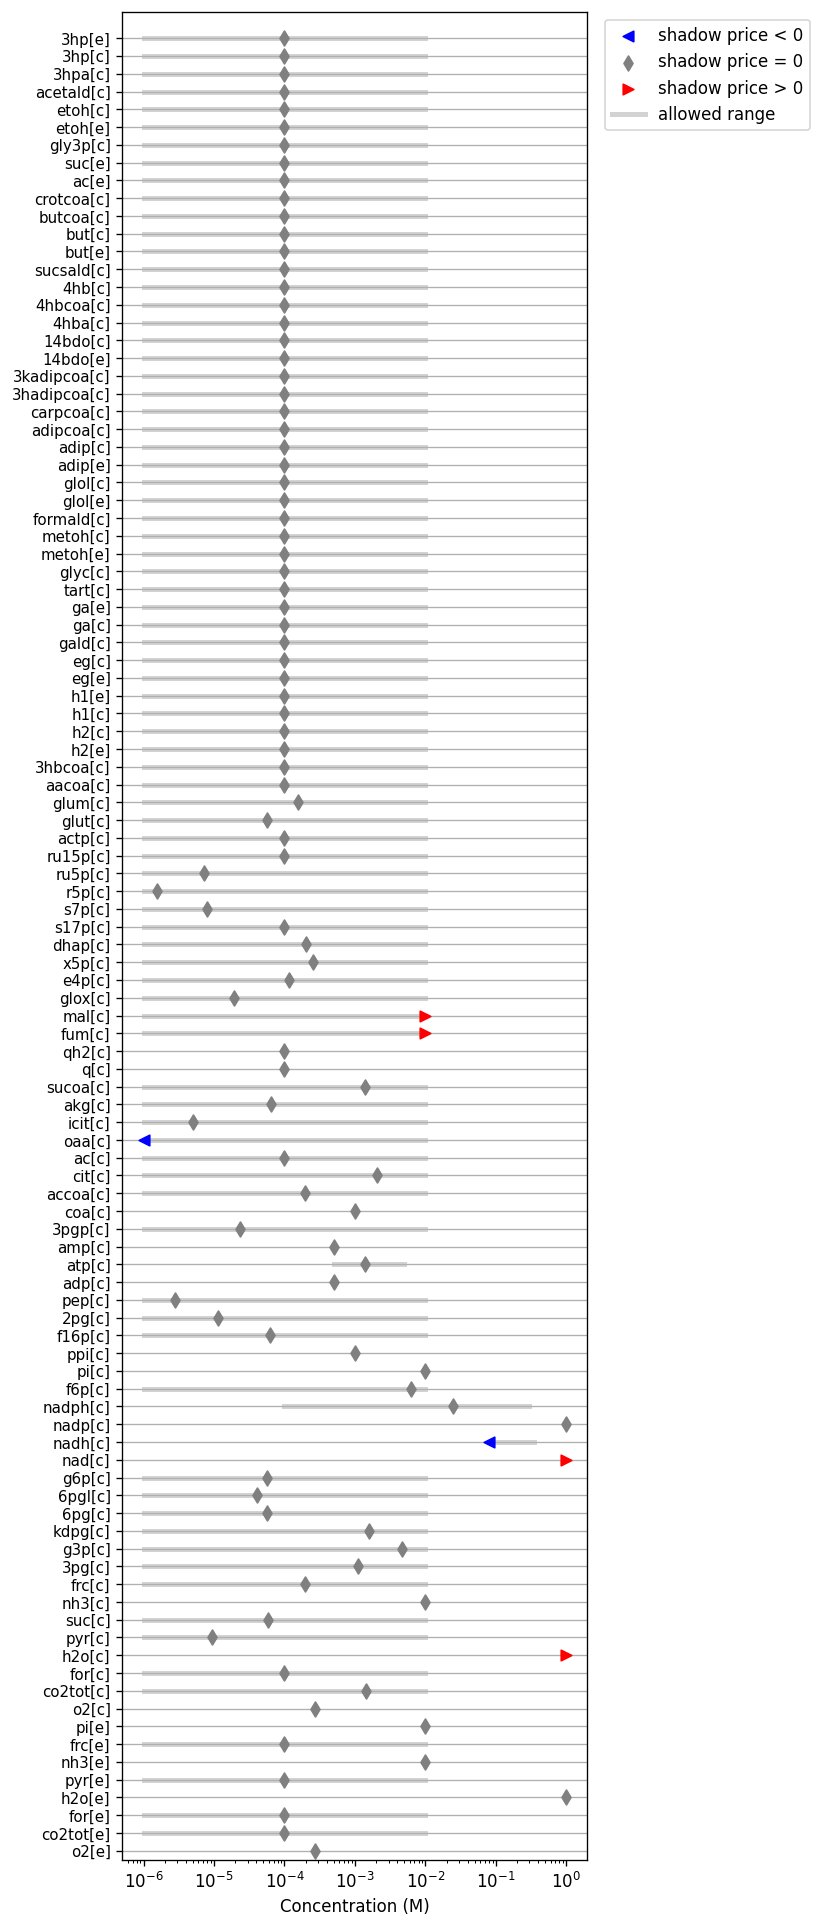

In [794]:
fig, ax = plt.subplots(1, 1, figsize=(5, 20), dpi=120)
mdf_sol.plot_concentrations(ax=ax)
ax.axes.yaxis.grid(True, which="major")

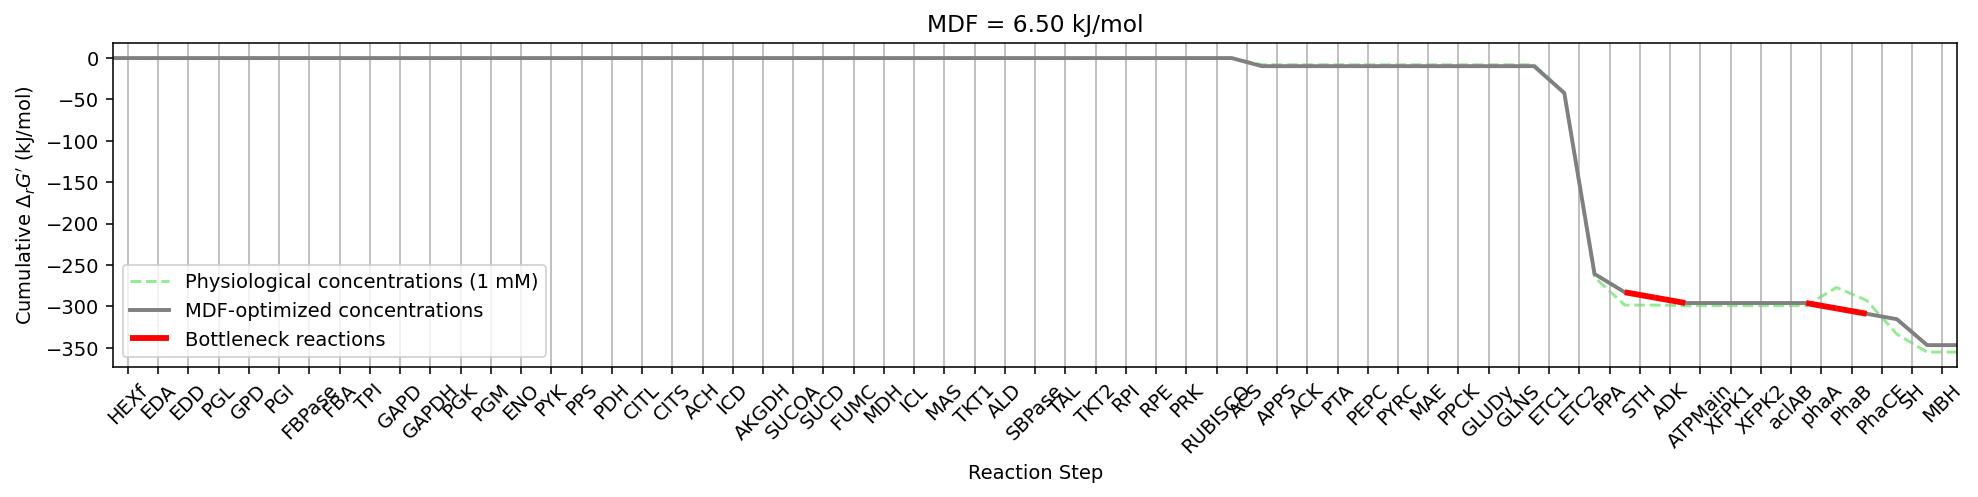

In [770]:
cnec_models['Acetate'].objective = 'Ex_PHB'
flux_bounds = {'Ex_CO2':(0,0), 'Ex_H2': (-1000, 1000), 'RUBISCO': (0,1000), 'Ex_Acetate':(1,1), 'ICL':(-1000,1000)}
fluxes = get_fluxes(cnec_models['Acetate'], flux_bounds, 'Ex_PHB')
solution = cobra.flux_analysis.pfba(cnec_models['Acetate'])

acetate_model = build_thermo_model(cnec_models['Acetate'], cnec_dict, compound_dict, fluxes)

mdf_sol = acetate_model.mdf_analysis()

fig, ax = plt.subplots(1, 1, figsize=(17, 3), dpi=140)
mdf_sol.plot_driving_forces(ax=ax)
ax.axes.xaxis.grid(True, which="major")

In [772]:
for reaction in cnec_models['Acetate'].reactions:
    print(reaction.id, solution[reaction.id])

Ex_O2 0.6666666666666667
Ex_CO2 0.0
Ex_H2 1.8333333333333335
Trp_H2 1.8333333333333335
Ex_H1 -1.8333333333333335
Trp_H1 1.8333333333333335
Ex_Biomass 0.0
Ex_H2O -2.3333333333333353
Ex_pi 0.0
Ex_NH3 0.0
Ex_PHB 0.5000000000000001
Trp_O2 0.6666666666666667
Trp_CO2 0.0
Trp_H2O 2.3333333333333353
Trp_piABC 0.0
Trp_pi 0.0
Trp_NH3 0.0
BIOMASS 0.0
HEXf 0.0
EDA 0.0
EDD 0.0
PGL 0.0
GPD 0.0
PGI 0.0
FBPase 0.0
FBA 0.0
TPI 0.0
GAPD 0.0
GAPDH -2.9817985569430776e-16
PGK -2.981798556943077e-16
PGM 2.981798556943077e-16
ENO 2.981798556943077e-16
PYK 0.0
PPS 0.0
PDH 0.0
CITL 0.0
CITS -1.4908992784715408e-16
ACH -1.4908992784715408e-16
ICD 1.4908992784715386e-16
AKGDH 1.4908992784715388e-16
SUCOA 1.4908992784715388e-16
SUCD -1.490899278471539e-16
FUMC -1.490899278471539e-16
MDH -4.472697835414618e-16
ICL -2.981798556943078e-16
MAS -2.981798556943078e-16
TKT1 0.0
ALD 0.0
SBPase 0.0
TAL 0.0
TKT2 0.0
RPI 0.0
RPE 0.0
PRK 0.0
RUBISCO 0.0
ACS 1.0
APPS 0.0
ACK 0.0
PTA 0.0
PEPC 0.0
PYRC 0.0
MAE 0.0
PPCK -2.9817

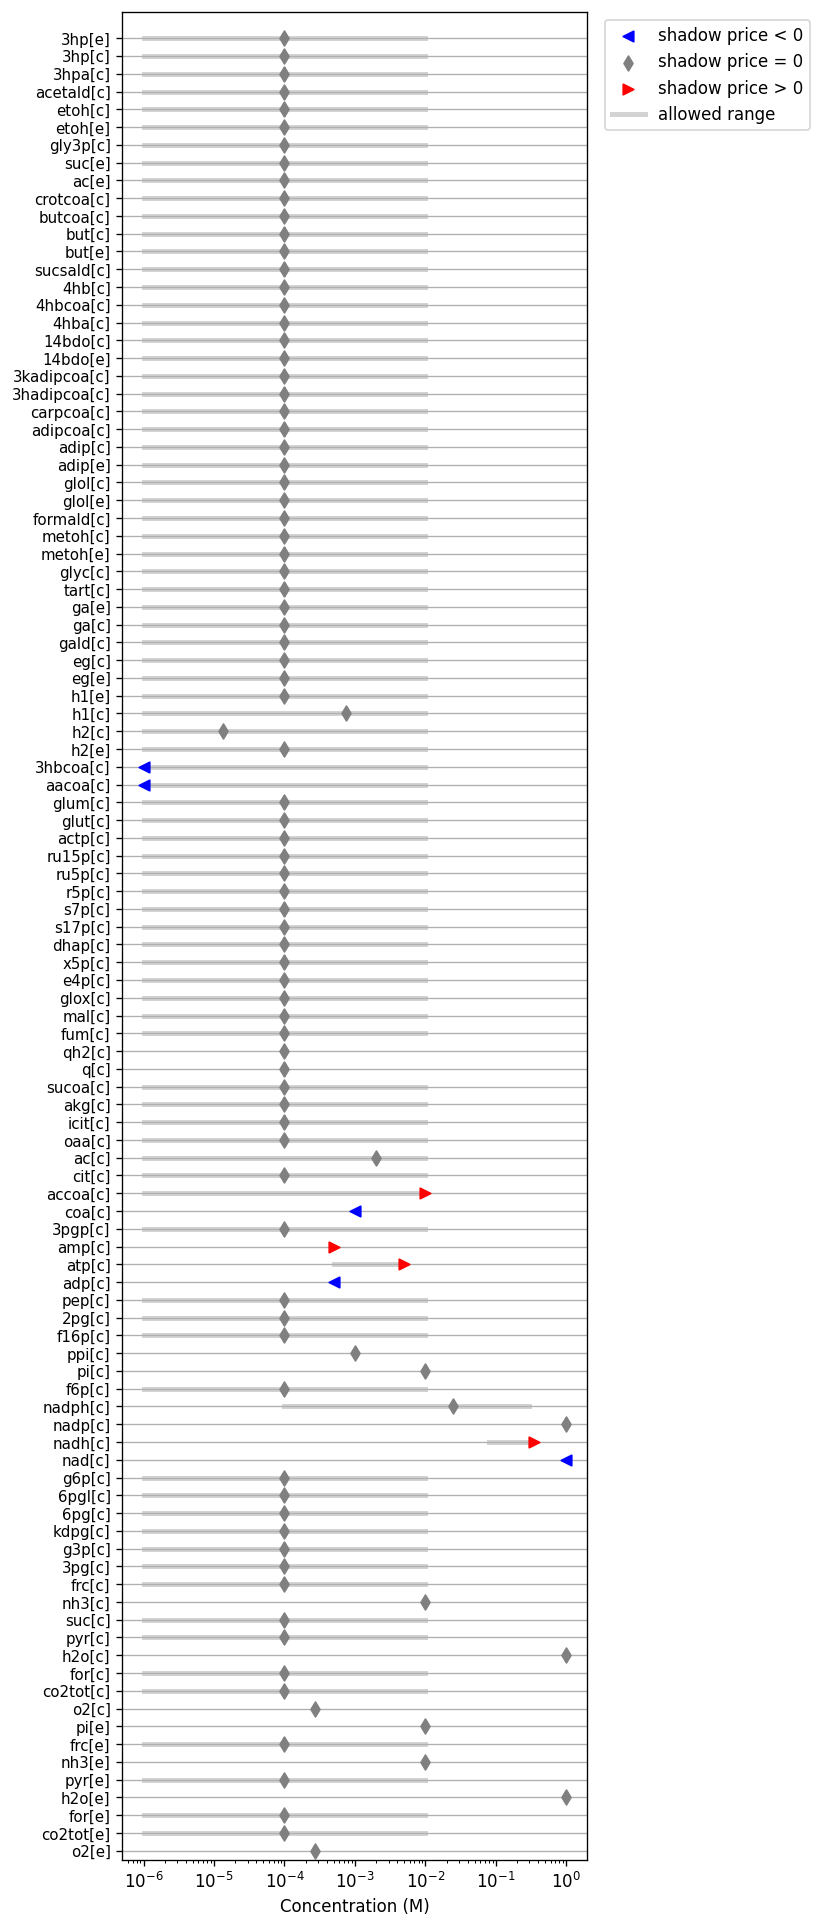

In [677]:
fig, ax = plt.subplots(1, 1, figsize=(5, 20), dpi=120)
mdf_sol.plot_concentrations(ax=ax)
ax.axes.yaxis.grid(True, which="major")

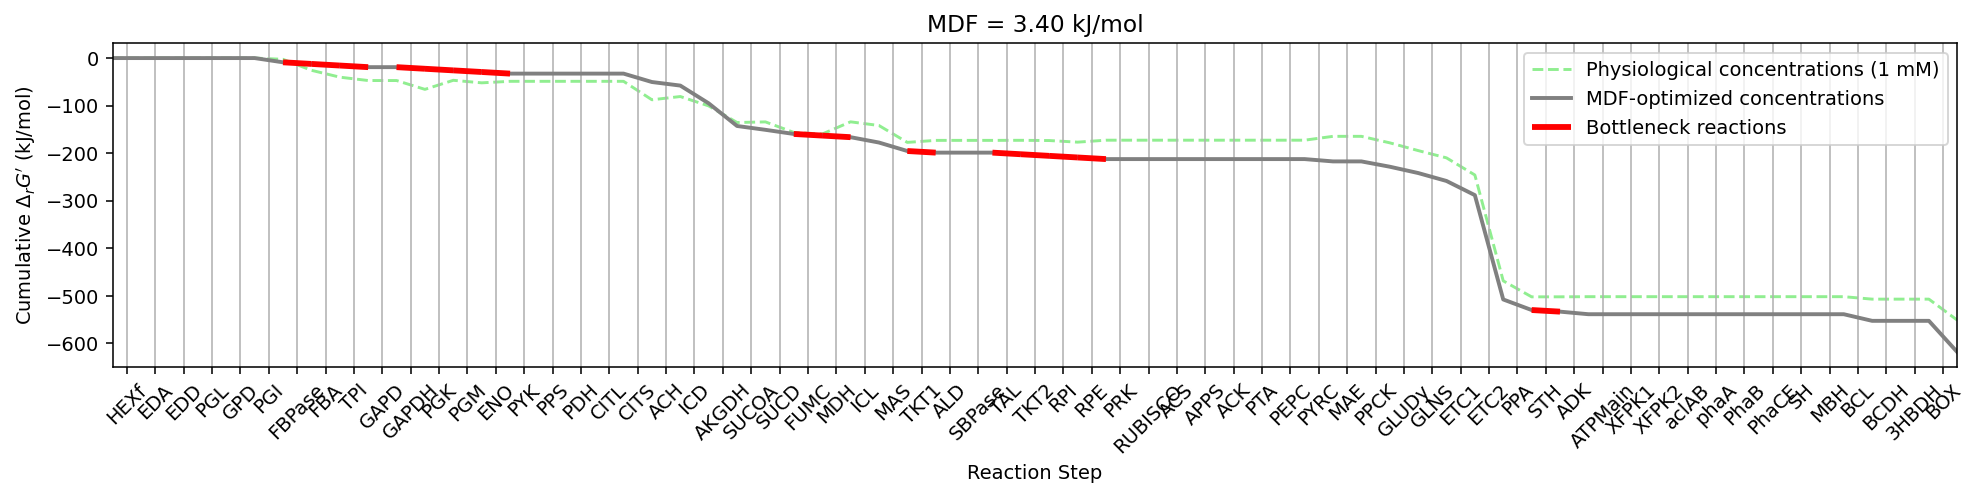

In [799]:
cnec_models['Butyrate'].objective = 'BIOMASS'
flux_bounds = {'Ex_CO2':(-1000,1000), 'Ex_H2': (0, 0), 'RUBISCO': (0,0), 'Ex_Butyrate':(1,1)}
fluxes = get_fluxes(cnec_models['Butyrate'], flux_bounds, 'BIOMASS')
solution = cobra.flux_analysis.pfba(cnec_models['Butyrate'])

butyrate_model = build_thermo_model(cnec_models['Butyrate'], cnec_dict, compound_dict, fluxes)

mdf_sol = butyrate_model.mdf_analysis()

fig, ax = plt.subplots(1, 1, figsize=(17, 3), dpi=140)
mdf_sol.plot_driving_forces(ax=ax)
ax.axes.xaxis.grid(True, which="major")

In [780]:
for reaction in cnec_models['Butyrate'].reactions:
    print(reaction.id, solution[reaction.id])

Ex_O2 1.0
Ex_CO2 -0.4444444444444445
Ex_H2 0.0
Trp_H2 0.0
Ex_H1 -0.11111111111111108
Trp_H1 0.11111111111111108
Ex_Biomass 0.0
Ex_H2O -0.8888888888888888
Ex_pi 0.0
Ex_NH3 0.0
Ex_PHB 0.8888888888888888
Trp_O2 1.0
Trp_CO2 -0.4444444444444445
Trp_H2O 0.888888888888889
Trp_piABC 0.0
Trp_pi 0.0
Trp_NH3 0.0
BIOMASS 0.0
HEXf 0.0
EDA 0.0
EDD 0.0
PGL 0.0
GPD 0.0
PGI 0.0
FBPase 0.0
FBA 0.0
TPI 0.0
GAPD 0.0
GAPDH 0.0
PGK 0.0
PGM 0.0
ENO 0.0
PYK 0.0
PPS 0.0
PDH 4.934324553889585e-17
CITL 0.0
CITS 0.22222222222222218
ACH 0.22222222222222218
ICD 0.22222222222222218
AKGDH 0.22222222222222218
SUCOA 0.22222222222222224
SUCD 0.22222222222222224
FUMC 0.2222222222222222
MDH 0.22222222222222224
ICL 0.0
MAS 0.0
TKT1 0.0
ALD 0.0
SBPase 0.0
TAL 0.0
TKT2 0.0
RPI 0.0
RPE 0.0
PRK 0.0
RUBISCO 0.0
ACS 0.0
APPS 0.0
ACK 0.0
PTA 0.0
PEPC 0.0
PYRC 4.934324553889585e-17
MAE 0.0
PPCK 0.0
GLUDy 0.0
GLNS 0.0
ETC1 0.7777777777777777
ETC2 1.0
PPA 1.0
STH 0.22222222222222224
ADK 1.0
ATPMain 0.0
XFPK1 0.0
XFPK2 0.0
aclAB 0.0


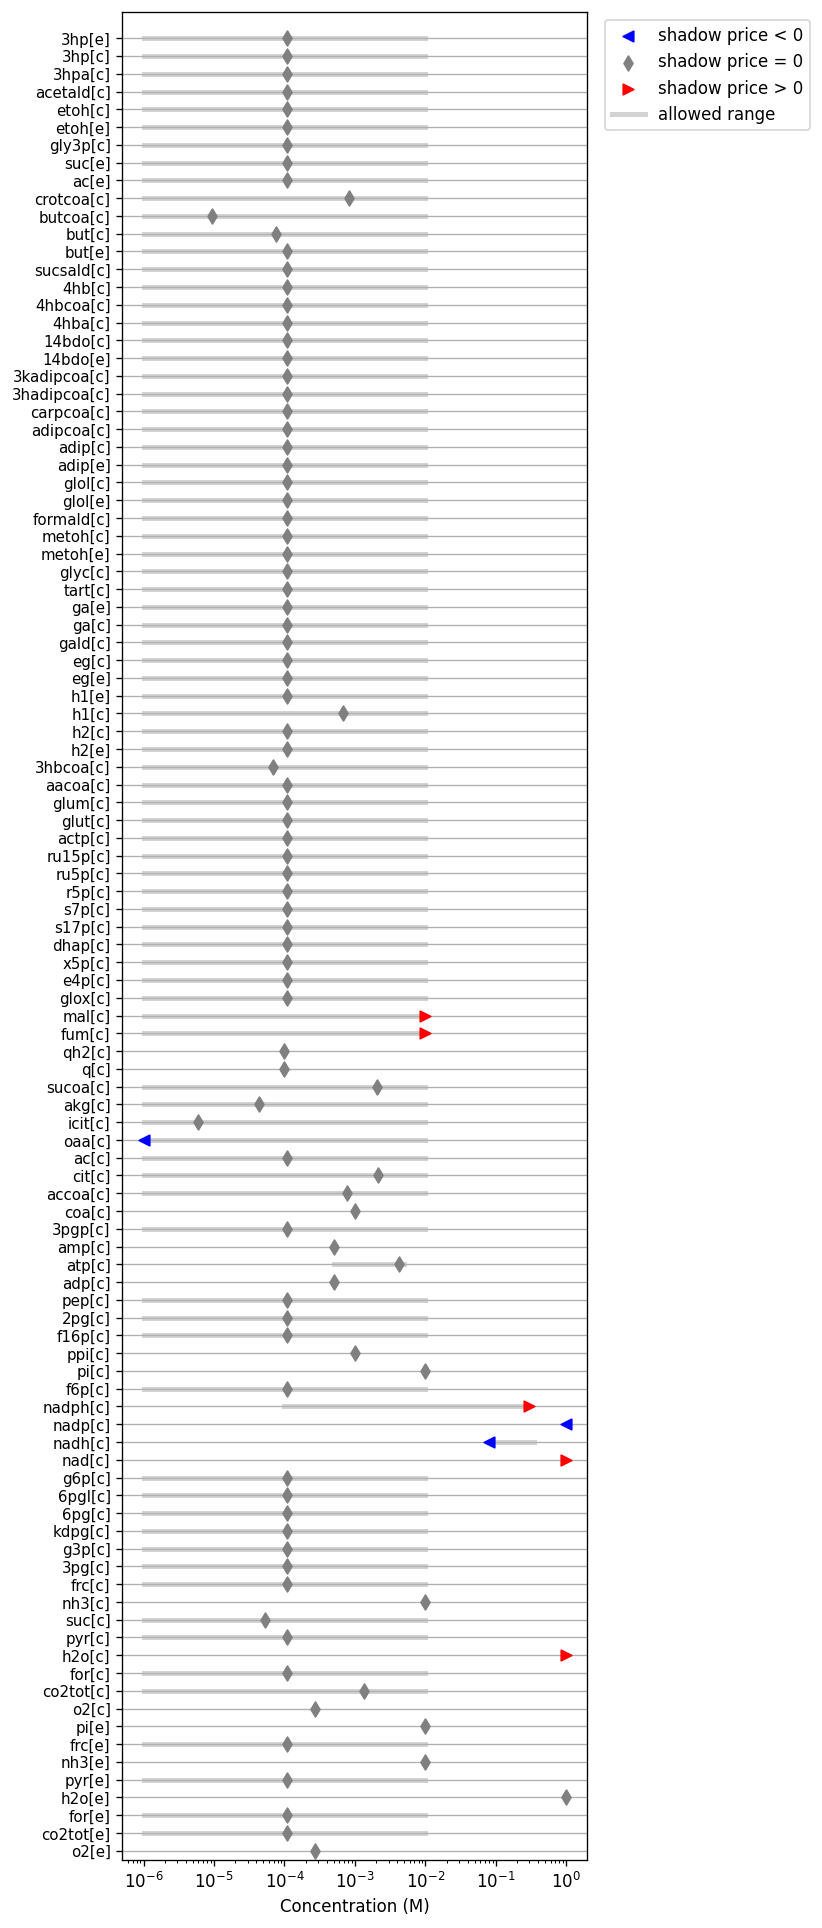

In [679]:
fig, ax = plt.subplots(1, 1, figsize=(5, 20), dpi=120)
mdf_sol.plot_concentrations(ax=ax)
ax.axes.yaxis.grid(True, which="major")

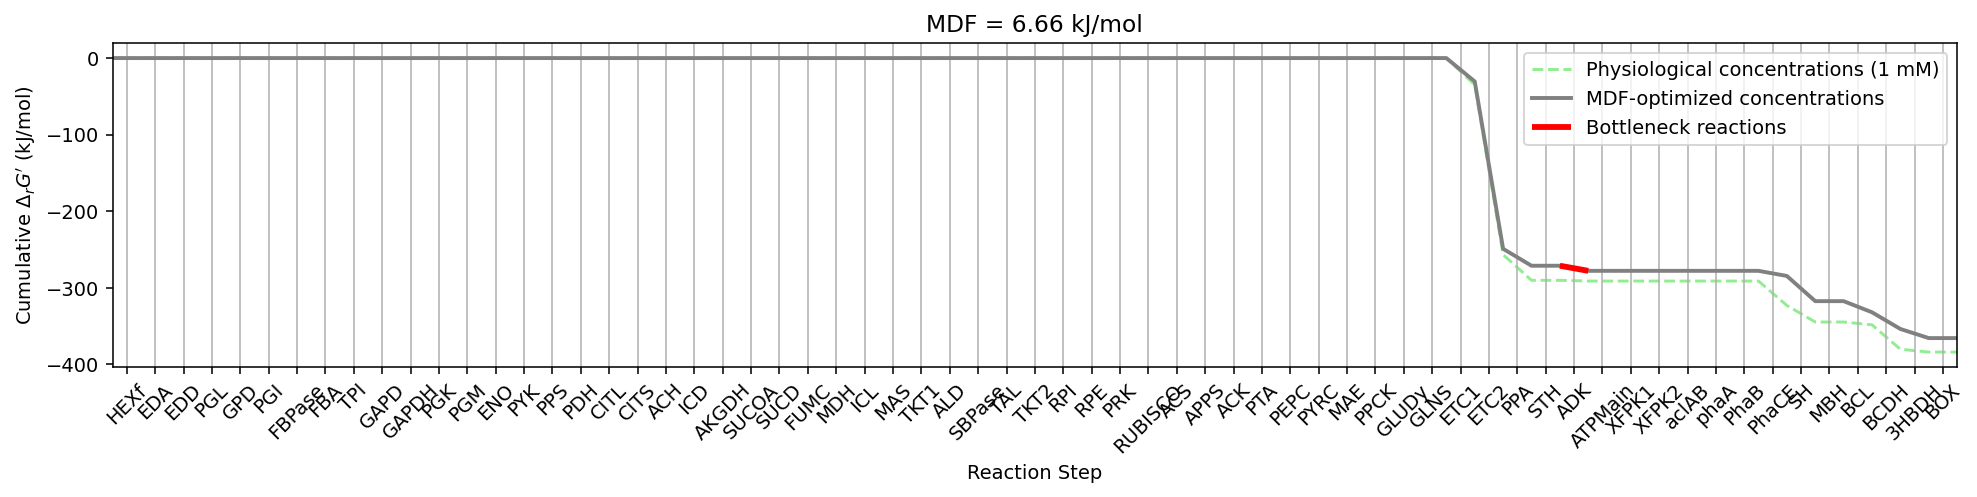

In [781]:
cnec_models['Butyrate'].objective = 'Ex_PHB'
flux_bounds = {'Ex_CO2':(0,0), 'Ex_H2': (-1000, 1000), 'RUBISCO': (0,1000), 'Ex_Butyrate':(1,1)}
fluxes = get_fluxes(cnec_models['Butyrate'], flux_bounds, 'Ex_PHB')
solution = cobra.flux_analysis.pfba(cnec_models['Butyrate'])

butyrate_model = build_thermo_model(cnec_models['Butyrate'], cnec_dict, compound_dict, fluxes)

mdf_sol = butyrate_model.mdf_analysis()

fig, ax = plt.subplots(1, 1, figsize=(17, 3), dpi=140)
mdf_sol.plot_driving_forces(ax=ax)
ax.axes.xaxis.grid(True, which="major")

In [782]:
for reaction in cnec_models['Butyrate'].reactions:
    print(reaction.id, solution[reaction.id])

Ex_O2 1.0
Ex_CO2 0.0
Ex_H2 1.0
Trp_H2 1.0
Ex_H1 -0.9999999999999999
Trp_H1 0.9999999999999999
Ex_Biomass 0.0
Ex_H2O -2.0
Ex_pi 0.0
Ex_NH3 0.0
Ex_PHB 0.9999999999999999
Trp_O2 1.0
Trp_CO2 0.0
Trp_H2O 2.0
Trp_piABC 0.0
Trp_pi 0.0
Trp_NH3 0.0
BIOMASS 0.0
HEXf 0.0
EDA 0.0
EDD 0.0
PGL 0.0
GPD 0.0
PGI 0.0
FBPase 0.0
FBA 0.0
TPI 0.0
GAPD 0.0
GAPDH 0.0
PGK 0.0
PGM 0.0
ENO 0.0
PYK 0.0
PPS 0.0
PDH 0.0
CITL 0.0
CITS 0.0
ACH 0.0
ICD 0.0
AKGDH 0.0
SUCOA 0.0
SUCD 0.0
FUMC 0.0
MDH 0.0
ICL 0.0
MAS 0.0
TKT1 0.0
ALD 0.0
SBPase 0.0
TAL 0.0
TKT2 0.0
RPI 0.0
RPE 0.0
PRK 0.0
RUBISCO 0.0
ACS 0.0
APPS 0.0
ACK 0.0
PTA 0.0
PEPC 0.0
PYRC 0.0
MAE 0.0
PPCK 0.0
GLUDy 0.0
GLNS 0.0
ETC1 1.0
ETC2 1.0
PPA 1.0
STH 0.0
ADK 1.0
ATPMain 0.0
XFPK1 0.0
XFPK2 0.0
aclAB 0.0
phaA 0.0
PhaB 0.0
PhaCE 1.0
SH 1.0
MBH 0.0
Ex_Butyrate 1.0
Trp_Butyrate 1.0
BCL 1.0
BCDH 1.0
3HBDH 1.0
BOX 0.0


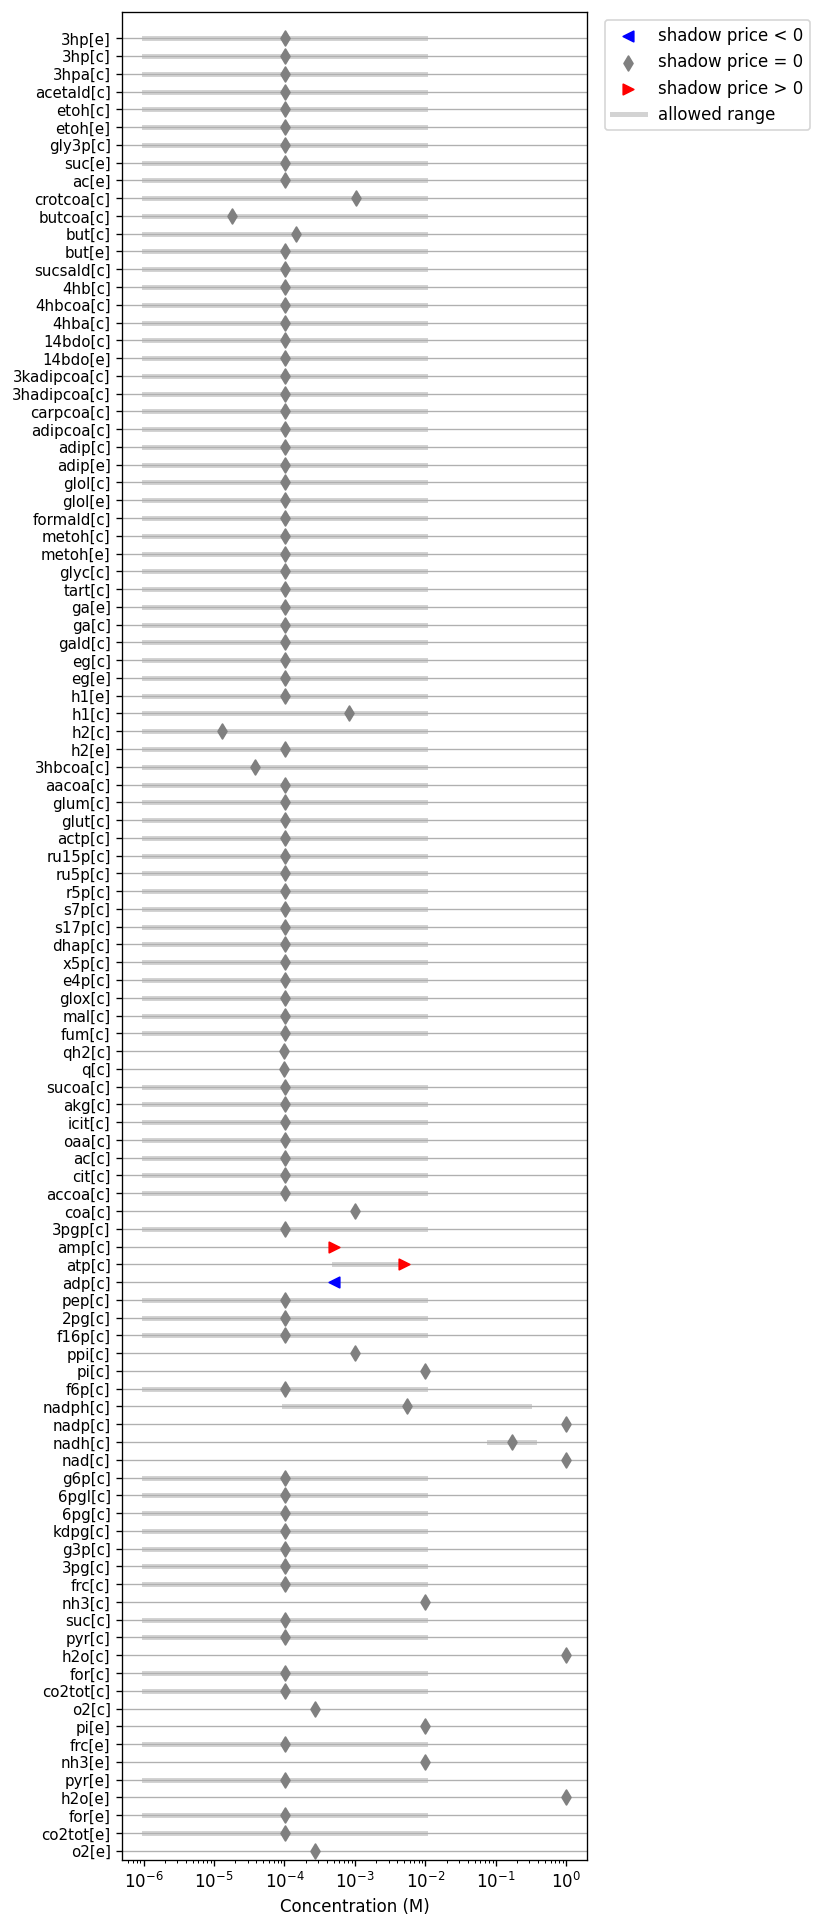

In [682]:
fig, ax = plt.subplots(1, 1, figsize=(5, 20), dpi=120)
mdf_sol.plot_concentrations(ax=ax)
ax.axes.yaxis.grid(True, which="major")

In [683]:
mixed_models = {}
pairs = []

for carbon1 in carbon_source:
    temp = {}
    if carbon1 == 'CO2':
        continue
    else:
        for carbon2 in carbon_source:
            if carbon2 == 'CO2':
                continue
            elif carbon1 == carbon2:
                temp[carbon2] = cnec_models[carbon1].copy()
                temp[carbon2].reactions.get_by_id('Ex_H2').bounds = (0,0)
                temp[carbon2].reactions.get_by_id('Ex_CO2').bounds = (-1000,1000)
            else:
                temp[carbon2], cnec_dict = add_modules(cnec_models[carbon1], 'Consumption_Modules_PCB_Submission.xlsx', carbon2, cnec_dict)
                temp[carbon2].reactions.get_by_id('Ex_'+carbon1).bounds = (1,1) #Force utilization of carbon1
                temp[carbon2].reactions.get_by_id('Ex_'+carbon2).bounds = (0,1) #Allow utilization of carbon2

                temp[carbon2].reactions.get_by_id('Ex_H2').bounds = (0,0)
                temp[carbon2].reactions.get_by_id('Ex_CO2').bounds = (-1000,1000)
    
    mixed_models[carbon1] = temp

In [684]:
c_efficiency = {}

for carbon1 in carbon_source:
    temp = {}
    if carbon1 == 'CO2':
        continue
    else:
        for carbon2 in carbon_source:
            if carbon2 == 'CO2':
                continue
            elif carbon1 == carbon2:
                try:
                    mixed_models[carbon1][carbon2].objective = 'Ex_PHB'
                    solution = cobra.flux_analysis.pfba(mixed_models[carbon1][carbon2])

                    PHB = solution['Ex_PHB']
                    C_flux = solution['Ex_'+carbon1]

                    efficiency = 4*solution['Ex_PHB']/(C_flux*carbon_source[carbon1][0])

                    temp[carbon2] = efficiency
                except:
                    print(carbon1+' infeasible')
                    temp[carbon2] = 0
            else:
                try:
                    mixed_models[carbon1][carbon2].objective = 'Ex_PHB'
                    solution = cobra.flux_analysis.pfba(mixed_models[carbon1][carbon2])

                    PHB = solution['Ex_PHB']
                    C1_flux = solution['Ex_'+carbon1]
                    C2_flux = solution['Ex_'+carbon2]

                    efficiency = 4*solution['Ex_PHB']/(C1_flux*carbon_source[carbon1][0]+C2_flux*carbon_source[carbon2][0])

                    temp[carbon2] = efficiency
                except:
                    print(carbon1+' and '+carbon2+' infeasible')
                    temp[carbon2] = 0
    c_efficiency[carbon1] = temp

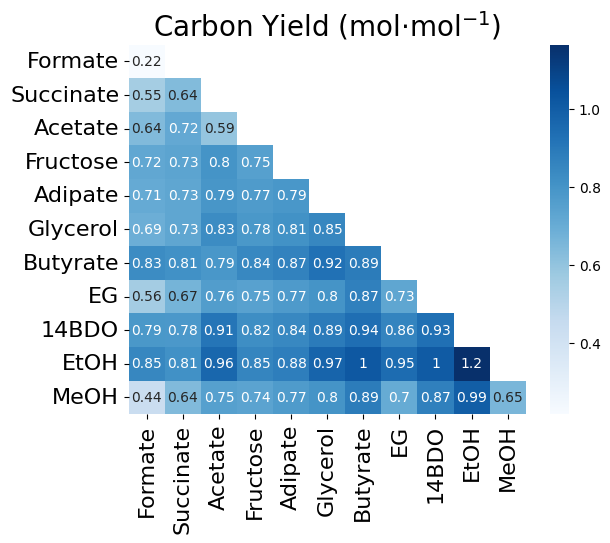

In [685]:
efficiency_df = pd.DataFrame(c_efficiency)
mask = np.triu(np.ones_like(efficiency_df))
mask[np.diag_indices_from(mask)] = False
g = sns.heatmap(efficiency_df, cmap = 'Blues', annot=True, mask=mask)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 16)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 16)

plt.title('Carbon Yield (mol$\cdot$mol$^{-1}$)', fontsize=20)
plt.show()

figure = g.get_figure()

#figure.savefig('carbon efficiency mixotrophy.pdf',bbox_inches = 'tight')

In [686]:
c_efficiency_eco2r = {}

for carbon1 in carbon_source:
    temp = {}
    if carbon1 == 'CO2':
        continue
    else:
        for carbon2 in carbon_source:
            if carbon2 == 'CO2':
                continue
            elif carbon1 == carbon2:
                try:
                    mixed_models[carbon1][carbon2].objective = 'Ex_PHB'
                    solution = cobra.flux_analysis.pfba(mixed_models[carbon1][carbon2])

                    PHB = solution['Ex_PHB']
                    C_flux = solution['Ex_'+carbon1]

                    efficiency = 4*solution['Ex_PHB']/(C_flux*carbon_source[carbon1][0])

                    temp[carbon2] = efficiency
                except:
                    print(carbon1+' infeasible')
                    temp[carbon2] = 0
            else:
                try:
                    mixed_models[carbon1][carbon2].objective = 'Ex_PHB'
                    solution = cobra.flux_analysis.pfba(mixed_models[carbon1][carbon2])

                    PHB = solution['Ex_PHB']
                    C1_flux = solution['Ex_'+carbon1]
                    C2_flux = solution['Ex_'+carbon2]
                    
                    if carbon2 in ['Formate', 'EG', 'EtOH', 'MeOH']:
                        efficiency = 4*solution['Ex_PHB']/(C1_flux*carbon_source[carbon1][0])
                    else:
                        continue
                        #efficiency = 4*solution['Ex_PHB']/(C1_flux*carbon_source[carbon1][0]+C2_flux*carbon_source[carbon2][0])

                    temp[carbon2] = efficiency
                except:
                    print(carbon1+' and '+carbon2+' infeasible')
                    temp[carbon2] = 0
    c_efficiency_eco2r[carbon1] = temp

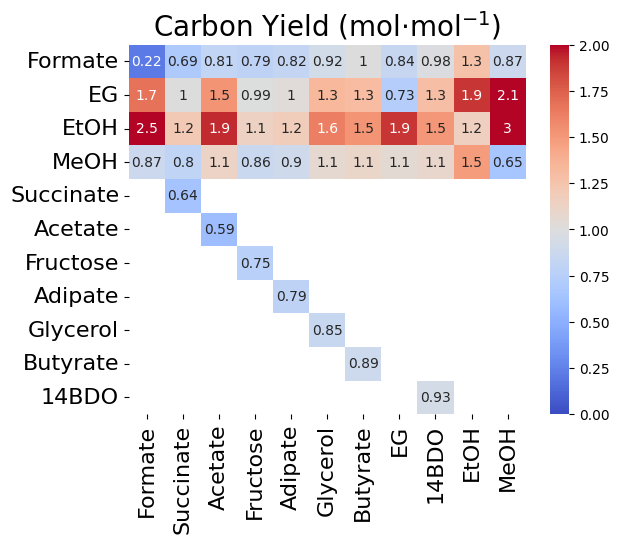

In [687]:
efficiency_df = pd.DataFrame(c_efficiency_eco2r)

g = sns.heatmap(efficiency_df, cmap = 'coolwarm', vmin = 0, vmax = 2, annot=True)#, mask=mask)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 16)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 16)
plt.title('Carbon Yield (mol$\cdot$mol$^{-1}$)', fontsize=20)
plt.show()


figure = g.get_figure()

#figure.savefig('carbon efficiency mixotrophy eCO2R.pdf',bbox_inches = 'tight')

In [688]:
mixed_mdfs = {}

for carbon1 in carbon_source:
    temp = {}
    if carbon1 == 'CO2':
        continue
    else:
        for carbon2 in carbon_source:
            
            if carbon2 == 'CO2':
                continue
            elif carbon1 == carbon2:
                
                mixed_models[carbon1][carbon2].objective = 'Ex_PHB'

                uptake_flux = 'Ex_'+carbon1
                
                if carbon1 == 'Acetate':
                    flux_bounds = {'Ex_CO2':(-1000,1000), 'Ex_H2':(0,0), 'RUBISCO':(0,1000), uptake_flux:(1,1), 'CITL':(0,0)}
                if carbon1 == 'Butyrate':
                    flux_bounds = {'Ex_CO2':(-1000,1000), 'Ex_H2':(0,0), 'RUBISCO':(0,1000), uptake_flux:(1,1), 'ACS':(0,0)}
                else:
                    flux_bounds = {'Ex_CO2':(-1000,1000), 'Ex_H2':(0,0), 'RUBISCO':(0,1000), uptake_flux:(1,1)}

                fluxes = get_fluxes(mixed_models[carbon1][carbon2], flux_bounds, 'Ex_PHB')
                model = build_thermo_model(mixed_models[carbon1][carbon2], cnec_dict, compound_dict, fluxes)
                
                try:
                    temp[carbon2] = model.mdf_analysis().score
                except:
                    print(carbon2)
                    continue

            else:
                mixed_models[carbon1][carbon2].objective = 'Ex_PHB'
                
                uptake_flux1 = 'Ex_'+carbon1
                uptake_flux2 = 'Ex_'+carbon2
                
                if carbon1 == 'Acetate' or carbon2 == 'Acetate':
                    flux_bounds = {'Ex_CO2':(-1000,1000), 'Ex_H2':(0,0), 'RUBISCO':(0,1000), uptake_flux1:(0,1), uptake_flux2:(0,1), 'CITL':(0,0)}
                if carbon1 == 'Butyrate' or carbon2 == 'Butyrate':
                    flux_bounds = {'Ex_CO2':(-1000,1000), 'Ex_H2':(0,0), 'RUBISCO':(0,1000), uptake_flux1:(0,1), uptake_flux2:(0,1), 'ACS':(0,0)}
                else:
                    flux_bounds = {'Ex_CO2':(-1000,1000), 'Ex_H2':(0,0), 'RUBISCO':(0,1000), uptake_flux1:(0,1), uptake_flux2:(0,1)}

                fluxes = get_fluxes(mixed_models[carbon1][carbon2], flux_bounds, 'Ex_PHB')
                model = build_thermo_model(mixed_models[carbon1][carbon2], cnec_dict, compound_dict, fluxes)
                
                try:
                    temp[carbon2] = model.mdf_analysis().score
                except:
                    print(carbon1, carbon2)
                    continue
                
    mixed_mdfs[carbon1] = temp

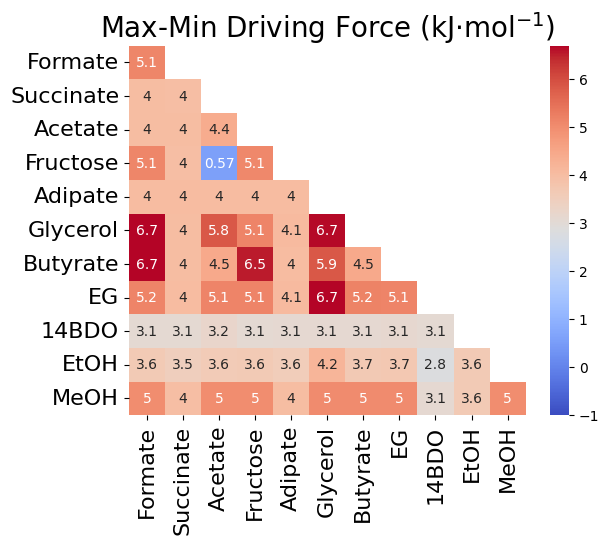

In [699]:
mdfs_df = pd.DataFrame(mixed_mdfs)
mask = np.triu(np.ones_like(mdfs_df))
mask[np.diag_indices_from(mask)] = False

fig, ax = plt.subplots(1,1)
g = sns.heatmap(mdfs_df, cmap = 'coolwarm', vmin = -1, vmax = 6.7, annot=True, mask=mask, ax=ax)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 16)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 16)
plt.title('Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=20)

figure = g.get_figure()

plt.show()
figure.savefig('mixed_mdfs.pdf',bbox_inches='tight')

Mixotrophy is generally thermodynamically feasible. Some combinations are less thermodynamically constrained than either single-consumption scenario (e.g. EG + Butyrate). Many mixotrophic scenarios are more carbon-efficient, but some are not. 

# CO$_2$-Free Mixotrophy

Of these scenarios, only ethanol alone is CO$_2$-free, even though C-C mixotrophy increases carbon efficiency. In order to yield CO$_2$-free mixotrophy, the paired carbon source must at least be able to drive assimilation of all of the CO$_2$ its oxidation produces. We know from the DOR analysis before that this is only possible if the carbon source does not have to fix any CO$_2$ at all! 

Acetate and ethanol are two such cases, though acetate does not generate its own energy and therefore must be paired with a CO$_2$-free energy source. Ethanol seems to produce sufficient energy to drive its own polymerization.

This line of thinking raises another possibility: partial oxidation + export of a valuable product. This is possible for glycerol (marginally) and EG (definitely), which can be partially oxidized to valuable acids, generated two reducing equivalents along the way.

In [700]:
cnec_models['EG_GA'] = cnec_models['EG'].copy()
cnec_models['EG_GA'].reactions.get_by_id('Trp_GA').bounds = (-1000,1000)
cnec_models['EG_GA'].reactions.get_by_id('Ex_GA').bounds = (-1000,0)
cnec_models['EG_GA'].reactions.get_by_id('GDH').bounds = (0,0)
cnec_models['EG_GA'].objective = 'Ex_PHB'

cnec_models['Glycerol_HP'] = cnec_models['Glycerol'].copy()
cnec_models['Glycerol_HP'].reactions.get_by_id('Ex_3HP').bounds = (-1000,1000)
cnec_models['Glycerol_HP'].reactions.get_by_id('Trp_3HP').bounds = (-1000,0)
cnec_models['Glycerol_HP'].reactions.get_by_id('GLDH').bounds = (-1000,1000)
cnec_models['Glycerol_HP'].reactions.get_by_id('HPADH').bounds = (0,1000)
cnec_models['Glycerol_HP'].reactions.get_by_id('GLYK').bounds = (0,0)
cnec_models['Glycerol_HP'].objective = 'Ex_PHB'

In [701]:
reassim_growth = {}
reassim_prod = {}

for carbon in cnec_models.keys():
    
    if carbon == 'EG_GA':
        uptake_flux = 'Ex_EG'
        flux_bounds = {'Ex_CO2': (0,1000), 'Ex_H2': (0, 0), 'RUBISCO': (0,1000), uptake_flux:(1,1)}
    elif carbon == 'Glycerol_HP':
        uptake_flux = 'Ex_Glycerol'
        flux_bounds = {'Ex_CO2': (0,1000), 'Ex_H2': (0, 0), 'RUBISCO': (0,1000), uptake_flux:(0,1)}
    else:
        uptake_flux = 'Ex_'+carbon
        flux_bounds = {'Ex_CO2': (0,1000), 'Ex_H2': (0, 0), 'RUBISCO': (0,1000), uptake_flux:(1,1)}
    
    if carbon == 'CO2':
        continue
    else:
        cnec_models[carbon].objective = 'Ex_PHB'
        
        try:
            fluxes = get_fluxes(cnec_models[carbon], flux_bounds, 'Ex_PHB')
            reassim_prod[carbon] = build_thermo_model(cnec_models[carbon], cnec_dict, compound_dict, fluxes)
        except:
            continue
        
        cnec_models[carbon].objective = 'BIOMASS'
        
        try:
            fluxes = get_fluxes(cnec_models[carbon], flux_bounds, 'BIOMASS')
            reassim_growth[carbon] = build_thermo_model(cnec_models[carbon], cnec_dict, compound_dict, fluxes)
        except:
            continue
        

mdfs_reassim_growth = {}
mdfs_reassim_prod = {}

for carbon in reassim_growth.keys():
    try:
        mdfs_reassim_growth[carbon] = reassim_growth[carbon].mdf_analysis().score
        mdfs_reassim_prod[carbon] = reassim_prod[carbon].mdf_analysis().score
    except:
        continue

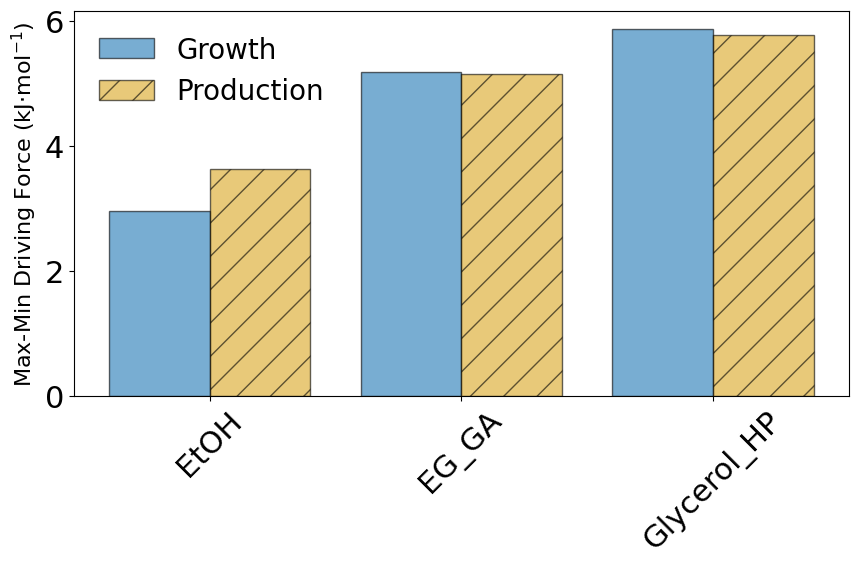

In [702]:
x = np.arange(len(mdfs_reassim_growth.keys()))
growth = [mdfs_reassim_growth[x] for x in mdfs_reassim_growth.keys()]
production = [mdfs_reassim_prod[x] for x in mdfs_reassim_growth.keys()]
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, growth, width, label = 'Growth', alpha = 0.6, edgecolor = "black")
ax.bar(x+width/2, production, width, label = 'Production', color = 'goldenrod',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)

ax.legend(frameon=False, loc = 'best', fontsize = 20)
ax.tick_params(axis='both', labelsize=22)

_=ax.set_xticks(ticks = x,labels = mdfs_reassim_growth.keys(), rotation =45)

#plt.savefig('reassimilation mdfs no H2.pdf', bbox_inches = 'tight')

Of all the single carbon sources, only ethanol, EG with GA overflow, and glycerol with 3HP overflow can support CO$_2$-free fermentation! In the latter two scenarios, valuable acids are co-products alongside the polymer.

In [723]:
mixed_models['EG']['Acetate'].reactions.get_by_id('CITL').bounds = (0,0)
mixed_models['EG']['Acetate'].reactions.get_by_id('ACK').bounds = (0,0)

mixed_models['EG']['Fructose'].reactions.get_by_id('PGI').bounds = (1,1)

In [724]:
eg_pairs_production = {}

for carbon in carbon_source:
    
    if carbon == 'CO2':
        continue
    else:
        flux_bounds = {'Ex_CO2': (0,1000), 
                       'Ex_H2': (0,0), 
                       'RUBISCO': (0,1000),
                       'Ex_'+carbon:(0,1), 
                       'Ex_GA':(-1000,0), 
                       'Trp_GA':(-1000,1000), 
                       'GDH':(0,0)}
        
        flux_bounds['Ex_EG'] = (0,1)
        
        mixed_models['EG'][carbon].objective = 'Ex_PHB'
        fluxes = get_fluxes(mixed_models['EG'][carbon], flux_bounds, 'Ex_PHB')
        test_model = build_thermo_model(mixed_models['EG'][carbon], cnec_dict, compound_dict, fluxes)
        mdf_sol = test_model.mdf_analysis().score
        
        solution = cobra.flux_analysis.pfba(mixed_models['EG'][carbon])

        co2flux = solution['Ex_CO2']
        phbflux = 4*solution['Ex_PHB']/(4*solution['Ex_PHB'] - 2*solution['Ex_GA'])
        gaflux = 2*solution['Ex_GA']/(4*solution['Ex_PHB'] - 2*solution['Ex_GA'])
        
    
    eg_pairs_production[carbon] = (mdf_sol, co2flux, phbflux, gaflux)

In [725]:
eg_pairs_growth = {}

for carbon in carbon_source:
    
    if carbon == 'CO2':
        continue
    else:
        flux_bounds = {'Ex_CO2': (0,1000), 
                       'Ex_H2': (0,0), 
                       'RUBISCO': (0,1000),
                       'Ex_'+carbon:(0,1), 
                       'Ex_GA':(-1000,0), 
                       'Trp_GA':(-1000,1000), 
                       'GDH':(0,0)}
        
        flux_bounds['Ex_EG'] = (0,1)
        
        mixed_models['EG'][carbon].objective = 'BIOMASS'
        fluxes = get_fluxes(mixed_models['EG'][carbon], flux_bounds, 'BIOMASS')
        test_model = build_thermo_model(mixed_models['EG'][carbon], cnec_dict, compound_dict, fluxes)
        mdf_sol = test_model.mdf_analysis().score
        
        solution = cobra.flux_analysis.pfba(mixed_models['EG'][carbon])

        co2flux = solution['Ex_CO2']
        phbflux = 4*solution['Ex_PHB']/(4*solution['Ex_PHB'] - 2*solution['Ex_GA'])
        gaflux = 2*solution['Ex_GA']/(4*solution['Ex_PHB'] - 2*solution['Ex_GA'])
        
    
    eg_pairs_growth[carbon] = (mdf_sol, co2flux, phbflux, gaflux)

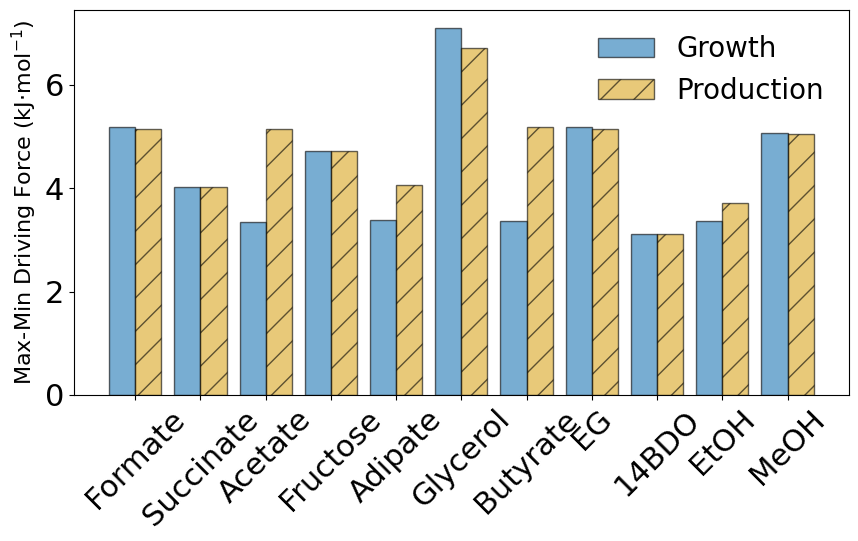

In [726]:
x = np.arange(len(eg_pairs_growth))
growth = [eg_pairs_growth[x][0] for x in eg_pairs_growth]
production = [eg_pairs_production[x][0] for x in eg_pairs_production]
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, growth, width, label = 'Growth', alpha = 0.6, edgecolor = "black")
ax.bar(x+width/2, production, width, label = 'Production', color = 'goldenrod',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 20)
ax.tick_params(axis='both', labelsize=22)

_=ax.set_xticks(ticks = x,labels = eg_pairs_growth.keys(), rotation =45)

plt.savefig('mixotrophic EG with GA export.pdf', bbox_inches = 'tight')

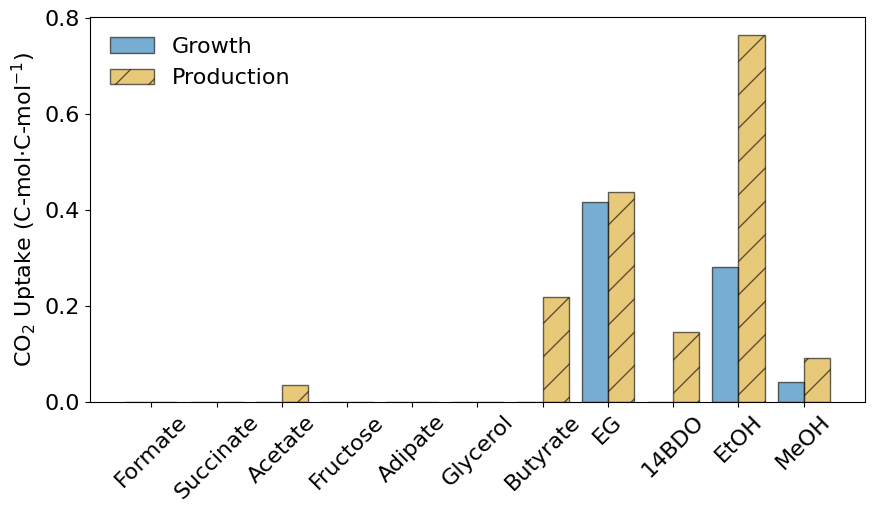

In [727]:
x = np.arange(len(eg_pairs_growth))
growth = [eg_pairs_growth[x][1] for x in eg_pairs_growth]
production = [eg_pairs_production[x][1] for x in eg_pairs_production]
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, growth, width, label = 'Growth', alpha = 0.6, edgecolor = "black")
ax.bar(x+width/2, production, width, label = 'Production', color = 'goldenrod',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'CO$_2$ Uptake (C-mol$\cdot$C-mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 16)
ax.tick_params(axis='both', labelsize=16)

_=ax.set_xticks(ticks = x,labels = eg_pairs_growth.keys(), rotation =45)

plt.savefig('mixotrophic EG CO2.pdf', bbox_inches = 'tight')

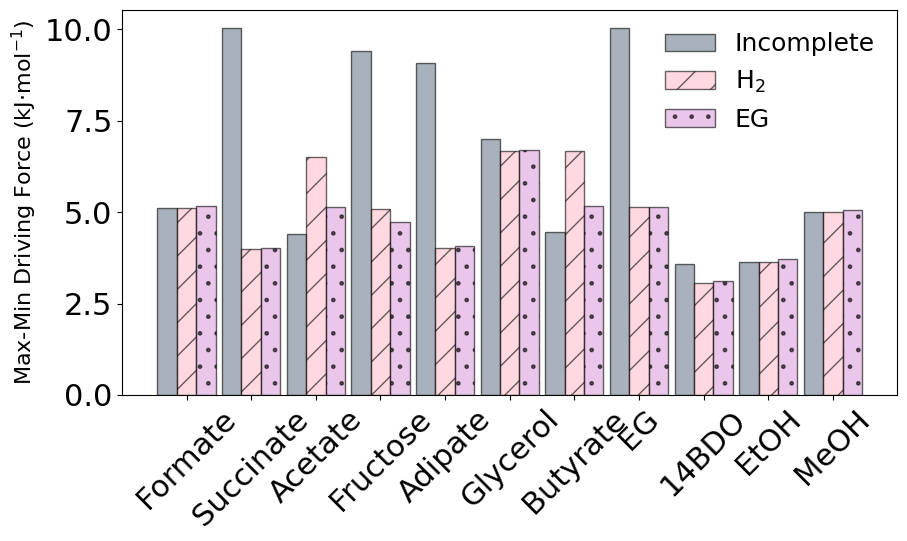

In [728]:
x = np.arange(len(mdfs_prod.keys())-1) 
no_reassim = [mdfs_prod[x] for x in mdfs_prod.keys() if x != 'CO2']
h2_reassim = [mdfs_reassim_prod[x] for x in mdfs_reassim_prod.keys() if x != 'CO2']
eg_reassim = [eg_pairs_production[x][0] for x in eg_pairs_production]

width = 0.3

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width, no_reassim, width, label = 'Incomplete', alpha = 0.6, color = 'slategrey', edgecolor = "black")
ax.bar(x, h2_reassim, width, label = r'H$_2$', color = 'pink',
       hatch = '/', alpha = 0.6, edgecolor = "black")
ax.bar(x+width, eg_reassim, width, label = 'EG', color = 'plum',
       hatch = '.', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 18)
ax.tick_params(axis='both', labelsize=22)

#ax.text(2.2, 10.5, '*', fontsize=20)
#ax.text(3.2, 10.5, '*', fontsize=20)
#ax.text(5.2, 10.5, '*', fontsize=20)

ax.yaxis.set_major_locator(plt.MaxNLocator(5))

_=ax.set_xticks(ticks = x, labels = [x for x in mdfs_reassim_prod.keys() if x!= 'CO2'], rotation =45)

plt.savefig('reassim_reassim_comparison_eg.pdf', bbox_inches = 'tight')

In [751]:
mixed_models['Glycerol']['Acetate'].reactions.get_by_id('CITL').bounds = (0,0)
mixed_models['Glycerol']['Acetate'].reactions.get_by_id('ACK').bounds = (0,0)

mixed_models['Glycerol']['Fructose'].reactions.get_by_id('PGI').bounds = (-1000,1000)

In [752]:
glyc_pairs_production = {}

for carbon in carbon_source:
    
    if carbon == 'CO2':
        continue
    else:
        flux_bounds = {'Ex_CO2': (0,1000), 
                       'Ex_H2': (0,0), 
                       'RUBISCO': (0,1000),
                       'Ex_'+carbon:(0,1), 
                       'Ex_3HP':(-1000,1000), 
                       'Trp_3HP':(-1000,0), 
                       'GLDH':(0,1000),
                       'HPADH':(0,1000),
                       'GLYK':(0,0)}
        
        flux_bounds['Ex_Glycerol'] = (0,1)
        mixed_models['Glycerol'][carbon].objective = 'Ex_PHB'
        fluxes = get_fluxes(mixed_models['Glycerol'][carbon], flux_bounds, 'Ex_PHB')
        test_model = build_thermo_model(mixed_models['Glycerol'][carbon], cnec_dict, compound_dict, fluxes)
        mdf_sol = test_model.mdf_analysis().score
        
        solution = cobra.flux_analysis.pfba(mixed_models['Glycerol'][carbon])

        co2flux = solution['Ex_CO2']
        phbflux = solution['Ex_PHB']
        hpflux = solution['Ex_3HP']
        
    
    glyc_pairs_production[carbon] = (mdf_sol, co2flux, phbflux, hpflux)

In [753]:
glyc_pairs_growth = {}

for carbon in carbon_source:
    
    if carbon == 'CO2':
        continue
    else:
        flux_bounds = {'Ex_CO2': (0,1000), 
                       'Ex_H2': (0,0), 
                       'RUBISCO': (0,1000),
                       'Ex_'+carbon:(0,1), 
                       'Ex_3HP':(-1000,1000), 
                       'Trp_3HP':(-1000,0), 
                       'GLDH':(-1000,1000),
                       'HPADH':(0,1000),
                       'GLYK':(0,0)}
        
        flux_bounds['Ex_Glycerol'] = (0,1)
        
        mixed_models['Glycerol'][carbon].objective = 'BIOMASS'
        fluxes = get_fluxes(mixed_models['Glycerol'][carbon], flux_bounds, 'BIOMASS')
        test_model = build_thermo_model(mixed_models['Glycerol'][carbon], cnec_dict, compound_dict, fluxes)
        mdf_sol = test_model.mdf_analysis().score
        
        solution = cobra.flux_analysis.pfba(mixed_models['Glycerol'][carbon])

        co2flux = solution['Ex_CO2']
        phbflux = solution['Ex_PHB']
        hpflux = solution['Ex_3HP']
        
    
    glyc_pairs_growth[carbon] = (mdf_sol, co2flux, phbflux, hpflux)

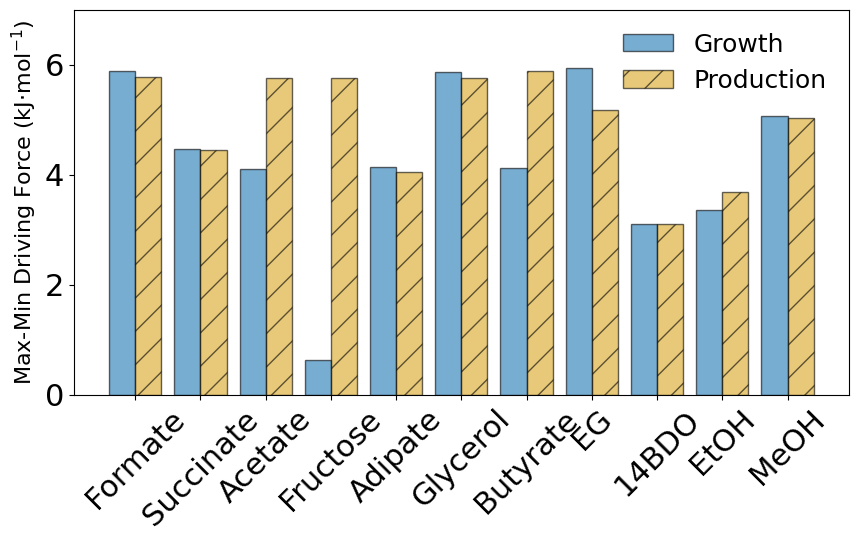

In [754]:
x = np.arange(len(glyc_pairs_growth))
growth = [glyc_pairs_growth[x][0] for x in glyc_pairs_growth]
production = [glyc_pairs_production[x][0] for x in glyc_pairs_production]
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, growth, width, label = 'Growth', alpha = 0.6, edgecolor = "black")
ax.bar(x+width/2, production, width, label = 'Production', color = 'goldenrod',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 18)
ax.set_ylim(0,7)
ax.tick_params(axis='both', labelsize=22)

_=ax.set_xticks(ticks = x,labels = glyc_pairs_growth.keys(), rotation =45)

#plt.savefig('mixotrophic Glyc with HP export.pdf', bbox_inches = 'tight')

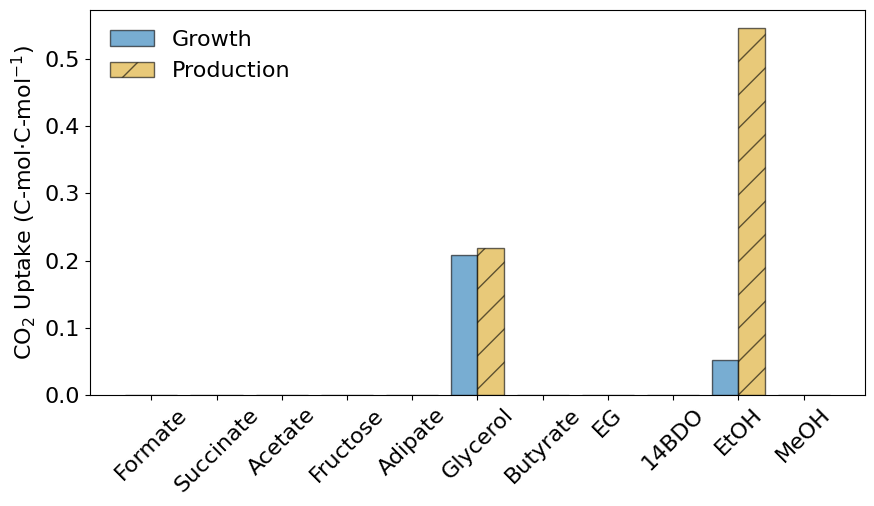

In [755]:
x = np.arange(len(eg_pairs_growth))
growth = [glyc_pairs_growth[x][1] for x in eg_pairs_growth]
production = [glyc_pairs_production[x][1] for x in eg_pairs_production]
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, growth, width, label = 'Growth', alpha = 0.6, edgecolor = "black")
ax.bar(x+width/2, production, width, label = 'Production', color = 'goldenrod',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'CO$_2$ Uptake (C-mol$\cdot$C-mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 16)
ax.tick_params(axis='both', labelsize=16)

_=ax.set_xticks(ticks = x,labels = glyc_pairs_growth.keys(), rotation =45)

#plt.savefig('mixotrophic Glyc CO2.pdf', bbox_inches = 'tight')

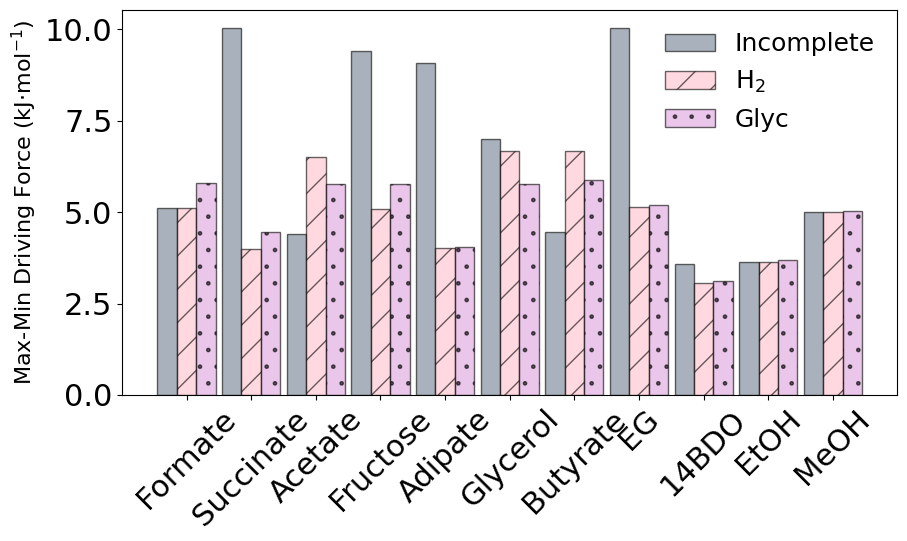

In [756]:
x = np.arange(len(mdfs_prod.keys())-1) 
no_reassim = [mdfs_prod[x] for x in mdfs_prod.keys() if x != 'CO2']
h2_reassim = [mdfs_reassim_prod[x] for x in mdfs_reassim_prod.keys() if x != 'CO2']
glyc_reassim = [glyc_pairs_production[x][0] for x in glyc_pairs_production]

width = 0.3

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width, no_reassim, width, label = 'Incomplete', alpha = 0.6, color = 'slategrey', edgecolor = "black")
ax.bar(x, h2_reassim, width, label = 'H$_2$', color = 'pink',
       hatch = '/', alpha = 0.6, edgecolor = "black")
ax.bar(x+width, glyc_reassim, width, label = 'Glyc', color = 'plum',
       hatch = '.', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.tick_params(axis='both', labelsize=22)

ax.yaxis.set_major_locator(plt.MaxNLocator(5))

#ax.text(2.2, 15.1, '*', fontsize=20)
#ax.text(3.2, 11, '*', fontsize=20)
#ax.text(6.2, 10.5, '*', fontsize=20)
#ax.text(9.2, 10.3, '*', fontsize=20)

ax.legend(frameon=False, loc = 'best', fontsize = 18)

_=ax.set_xticks(ticks = x, labels = [x for x in mdfs_reassim_prod.keys() if x!= 'CO2'], rotation =45)

#plt.savefig('reassim_reassim_comparison_glyc.pdf', bbox_inches = 'tight')